# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

# <div style='padding:7px;background-color:Maroon;color:white;border-radius:2px;font-size:100%;text-align: center'>CLassification Modeling<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [5]:
! jt -l

zsh:1: command not found: jt


In [2]:
! jt -t chesterish

zsh:1: command not found: jt


In [2]:
import pandas as pd
pd.options.display.max_columns = None
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)

import numpy as np

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})

from imblearn.combine import SMOTETomek

from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler, label_binarize, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, balanced_accuracy_score
import xgboost as xg

from sklearn import svm

import pickle
import os




## <span style="color:Aqua;">Reading model dataset:</span>

In [183]:
df = pd.read_feather('transfered_data.feather')
df.sample(3)

months_as_customer policy_bind_date policy_state  policy_deductable  \
895                 156       2009-09-16           IL                500   
451                  88       1992-08-05           IN               1000   
127                 165       2012-06-04           IN                500   

    insured_sex insured_education_level insured_occupation insured_hobbies  \
895        MALE             High School       armed-forces     board-games   
451      FEMALE                 College   transport-moving         reading   
127      FEMALE             High School       tech-support        exercise   

    insured_relationship incident_date             incident_type  \
895            own-child    2015-02-17   Multi-vehicle Collision   
451              husband    2015-02-25  Single Vehicle Collision   
127            own-child    2015-02-08                Parked Car   

      collision_type incident_severity authorities_contacted incident_state  \
895  Front Collision      Major Damage                  Fire             WV   
451   Side Collision        Total Loss                  Fire             SC   
127           Others      Minor Damage                Police             PA   

    incident_city incident_hour_of_the_day number_of_vehicles_involved  \
895     Northbend                       23                           3   
451    Northbrook                        3                           1   
127    Northbrook                        9                           1   

    property_damage bodily_injuries witnesses police_report_available  \
895             YES               0         3                      NO   
451              NO               2         0                     YES   
127             YES               2         0                     YES   

     auto_make auto_year fraud_reported  age_boxcox  \
895       Saab      1998              Y      4.1851   
451  Chevrolet      2003              N      3.8769   
127        BMW      1998              N      3.9605   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
895                     1371.8577                114355.1071   
451                     1442.0374                116134.6551   
127                     1403.2571                  6764.3420   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  
895             -32768               -28672            89238.7279  
451              12288                    0            97706.2294  
127              23272               -10432             5483.7986

In [12]:
ordinal = ['insured_education_level','incident_severity',]

nominal = ['policy_state','insured_sex','insured_occupation','insured_hobbies','insured_relationship','incident_type',
           'collision_type','authorities_contacted','incident_state','incident_city','property_damage',
           'police_report_available','auto_make','fraud_reported']

discrete = ['months_as_customer','incident_hour_of_the_day','number_of_vehicles_involved','auto_year'
            ,'witnesses','bodily_injuries']
continuous = [
    'age_boxcox','policy_annual_premium_boxcox','total_claim_amount_boxcox','injury_claim_cube',
    'property_claim_cube','vehicle_claim_boxcox','insurance_age','vehicle_age','auto_year','policy_deductable']

date = ['policy_bind_date','incident_date']

len(ordinal + nominal + discrete +continuous + date)

34

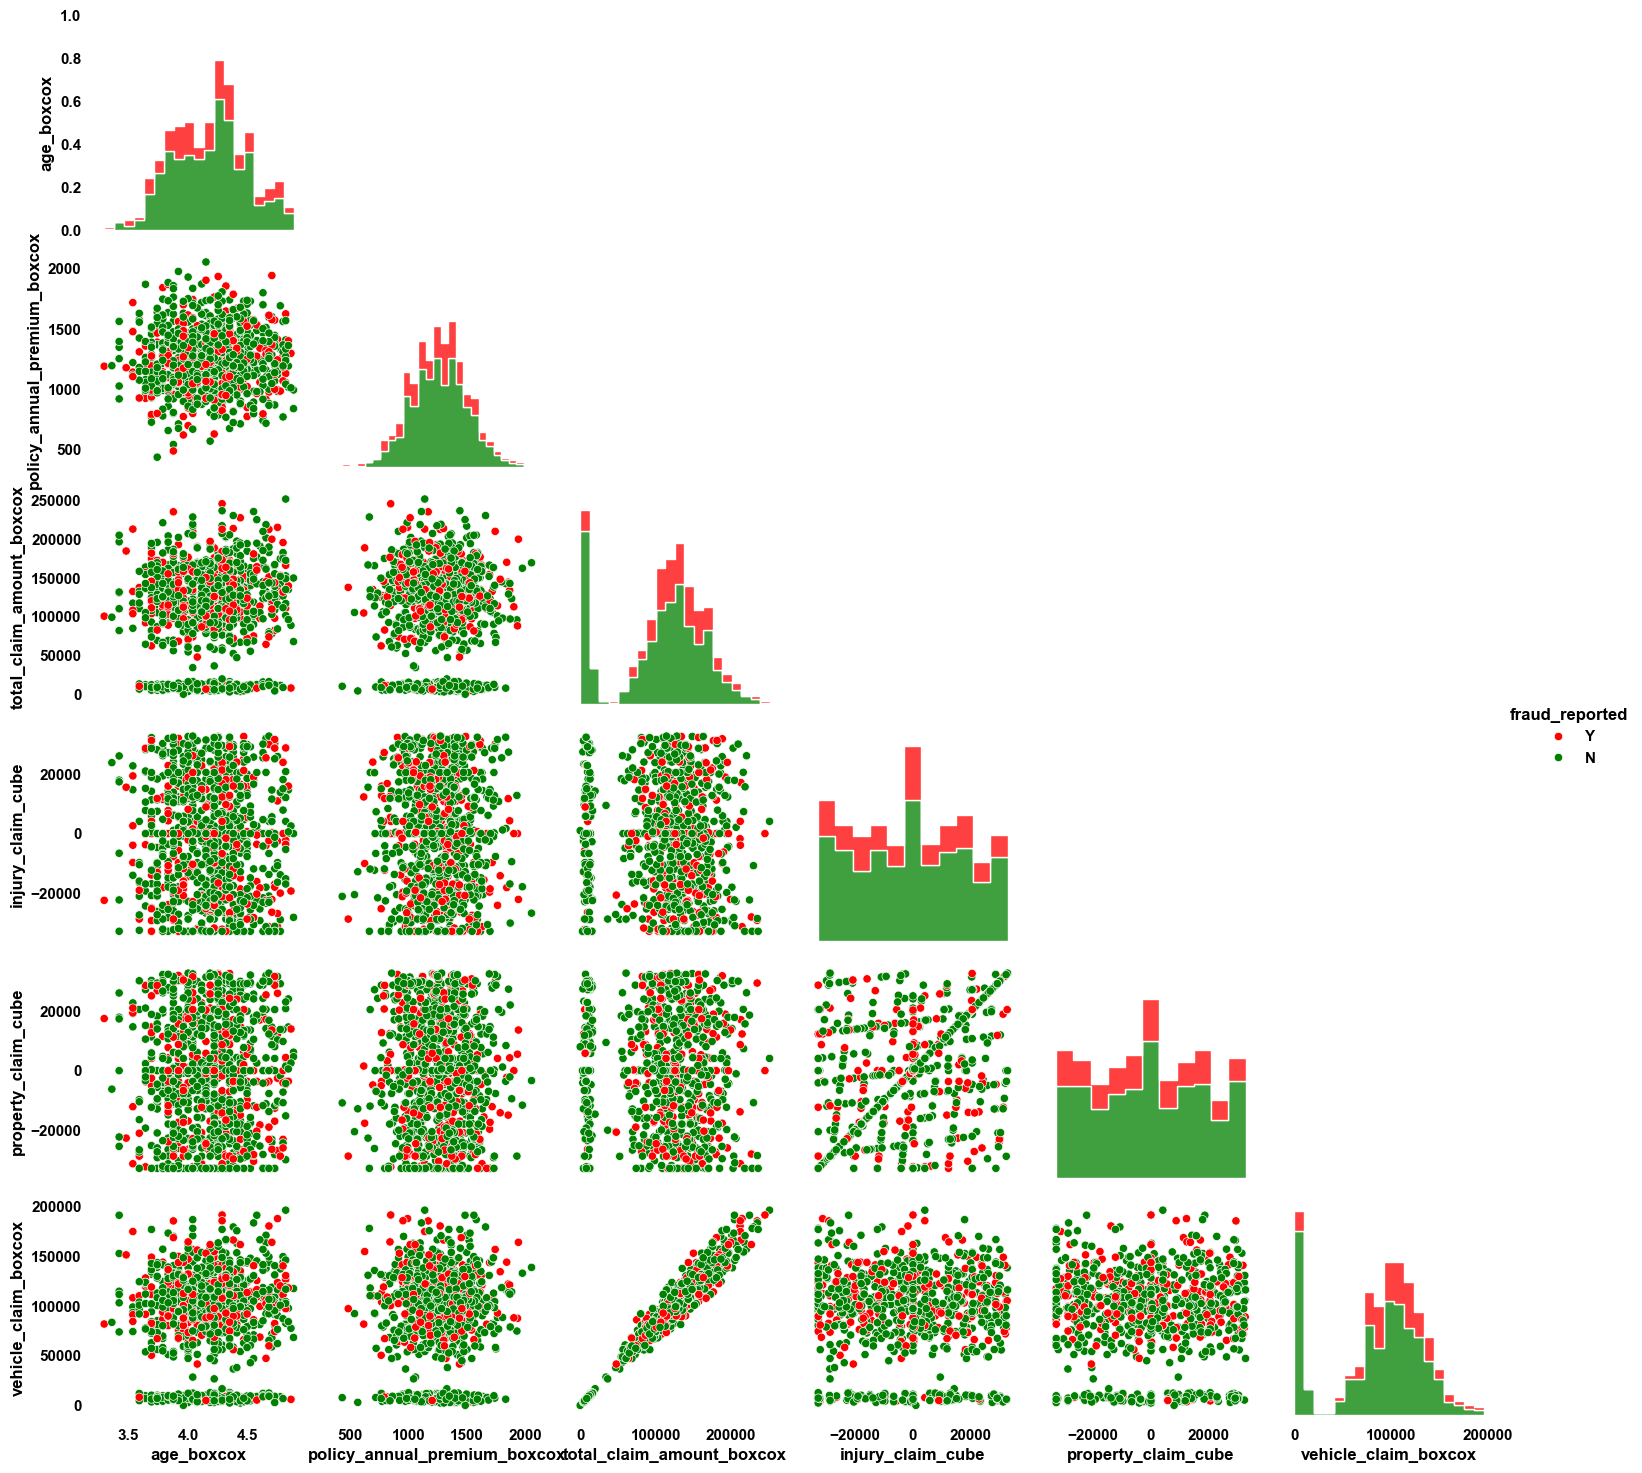

In [92]:
grid = sns.PairGrid(df,vars = [
    'age_boxcox','policy_annual_premium_boxcox','total_claim_amount_boxcox','injury_claim_cube',
    'property_claim_cube','vehicle_claim_boxcox',] , hue='fraud_reported',hue_order=['Y','N'],palette=['red','green'])
grid = grid.map_lower(sns.scatterplot)
grid = grid.map_diag(sns.histplot,multiple="stack",element='step')

grid.add_legend()

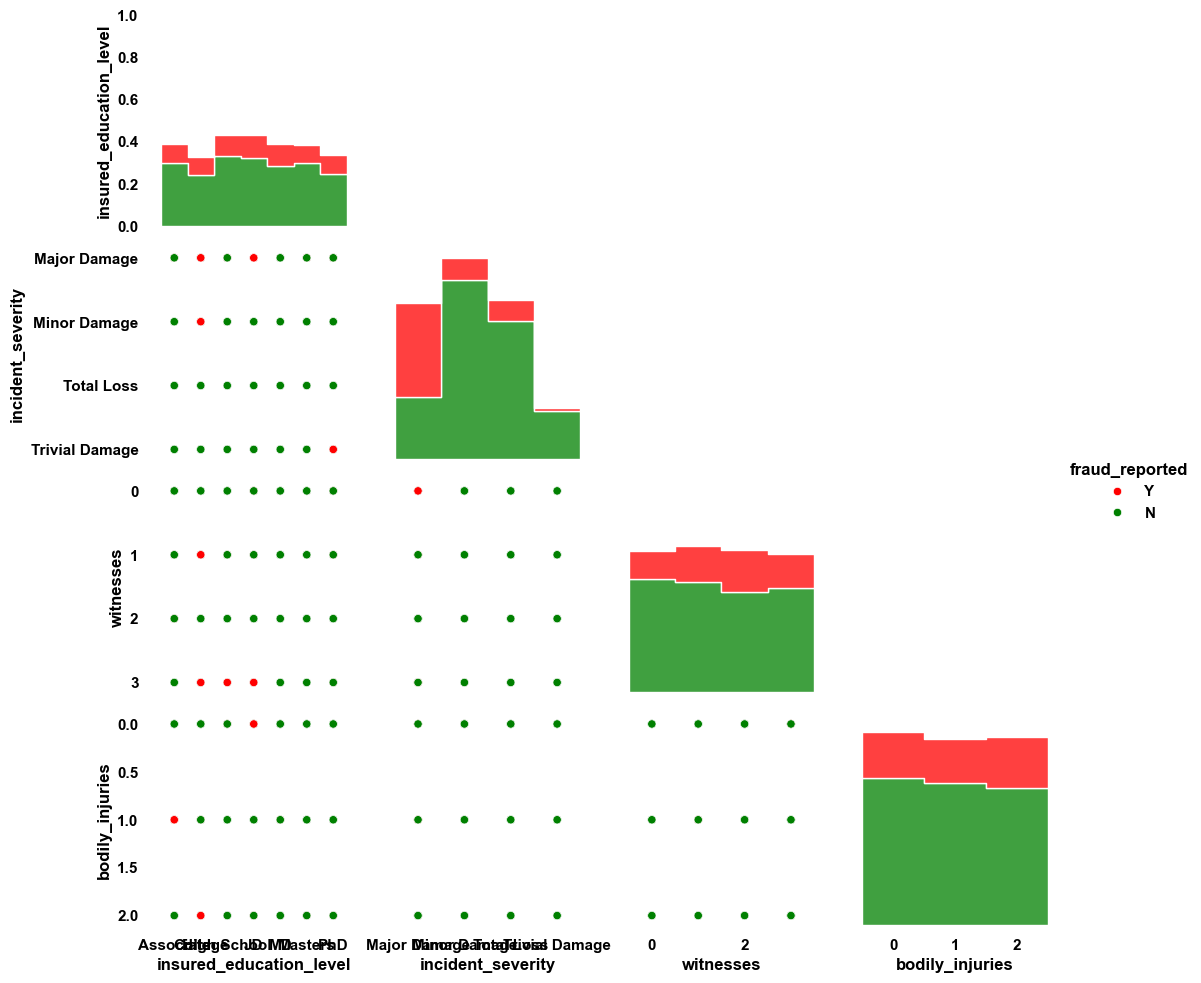

In [93]:
grid = sns.PairGrid(df,vars = ['insured_education_level','incident_severity','witnesses','bodily_injuries',] , 
                    hue='fraud_reported',hue_order=['Y','N'],palette=['red','green'])
grid = grid.map_lower(sns.scatterplot)
grid = grid.map_diag(sns.histplot,multiple="stack",element="step")

grid.add_legend()

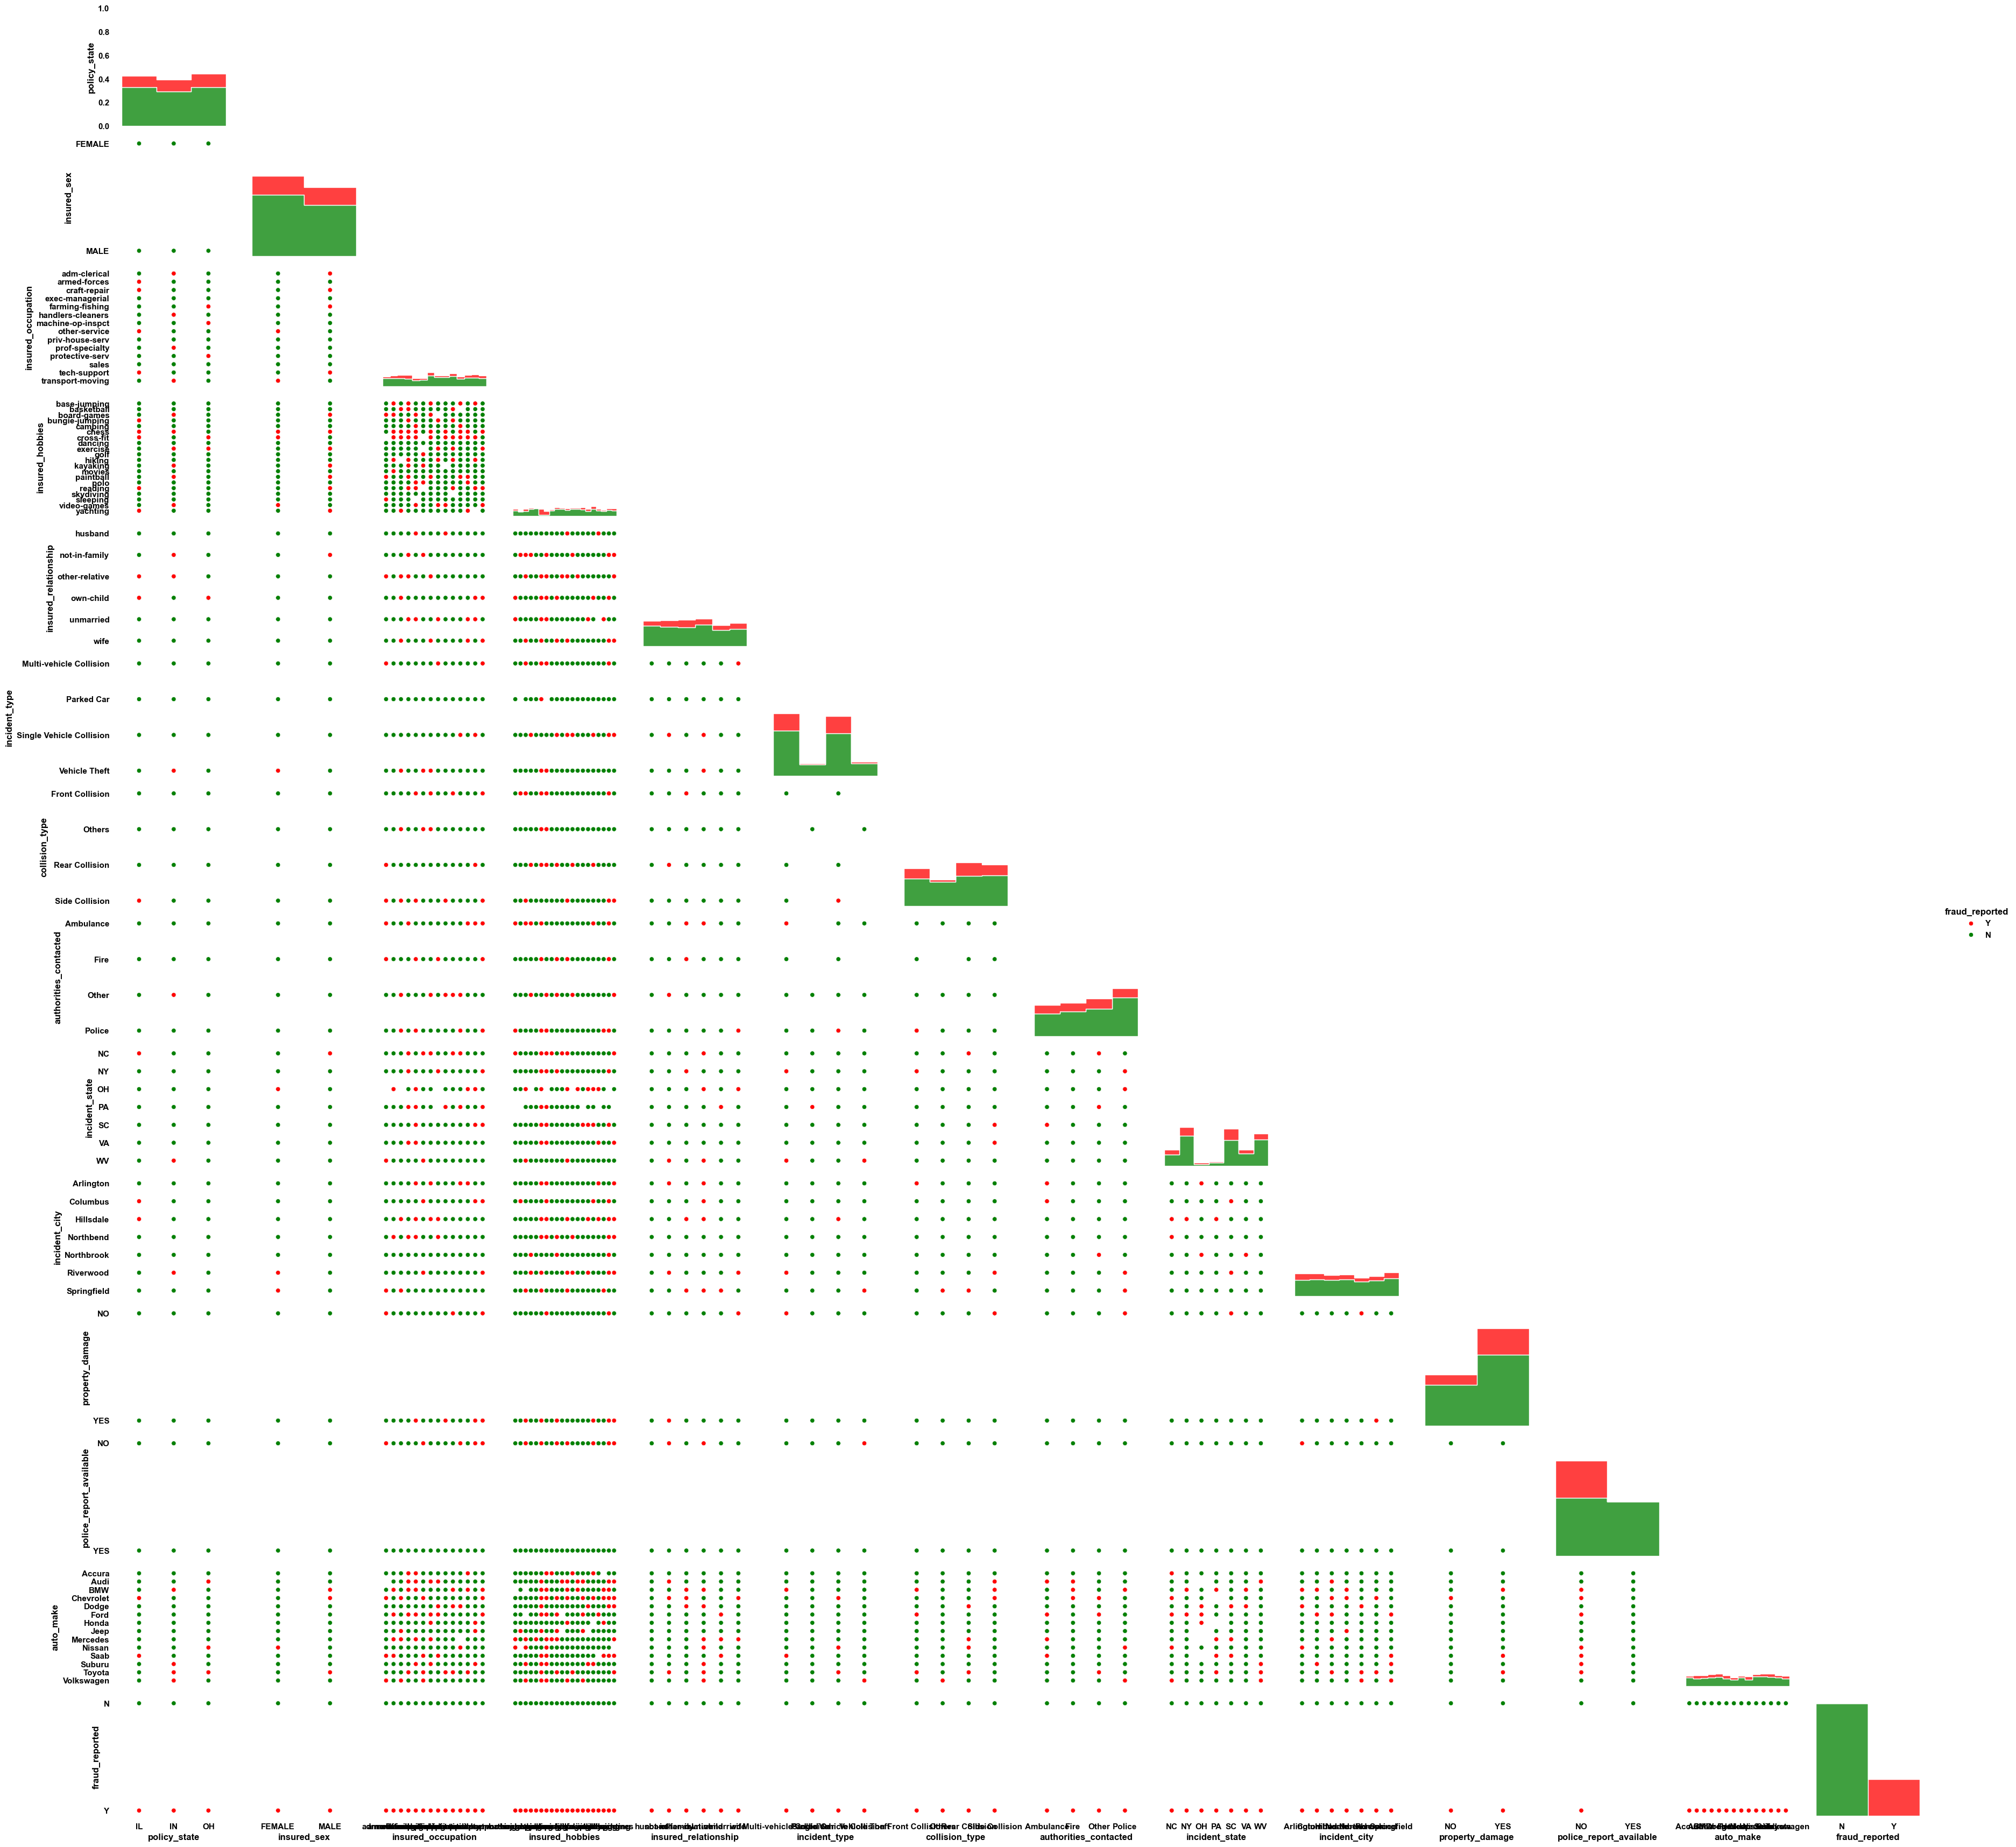

In [94]:
grid = sns.PairGrid(df,vars = ['policy_state','insured_sex','insured_occupation','insured_hobbies','insured_relationship','incident_type',
           'collision_type','authorities_contacted','incident_state','incident_city','property_damage',
           'police_report_available','auto_make','fraud_reported'], 
                    hue='fraud_reported',hue_order=['Y','N'],palette=['red','green'])
grid = grid.map_lower(sns.scatterplot)
grid = grid.map_diag(sns.histplot,multiple="stack",element="step")

grid.add_legend()

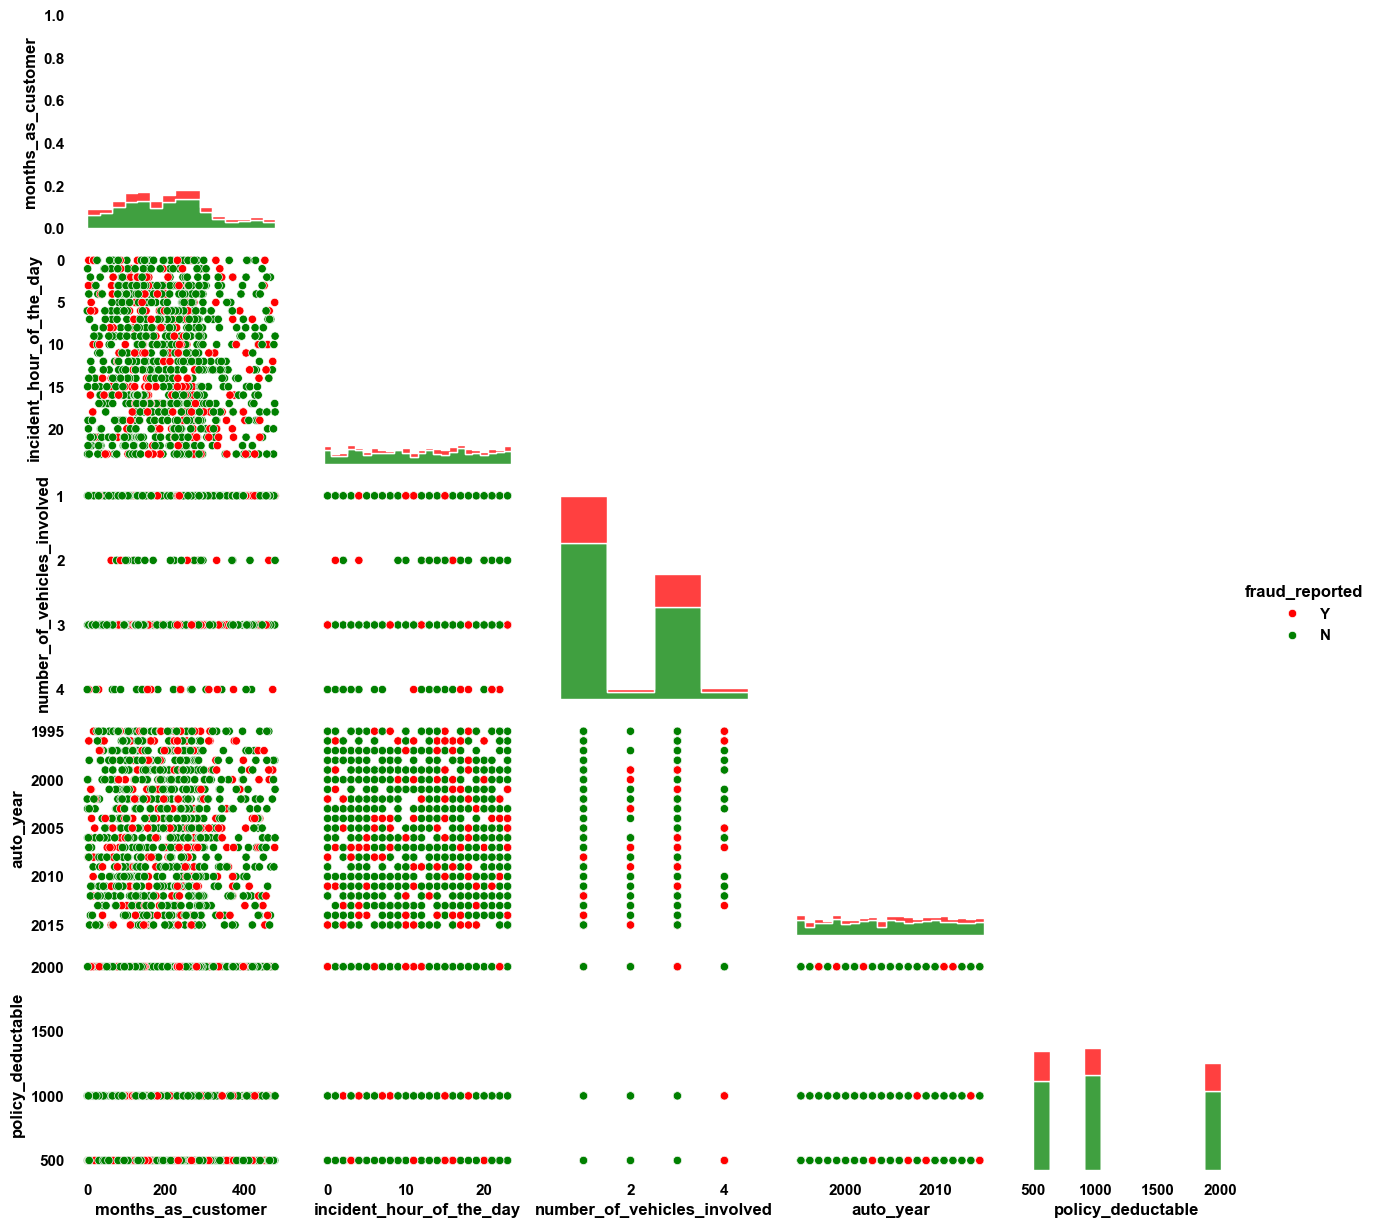

In [95]:
grid = sns.PairGrid(df,vars = ['months_as_customer','incident_hour_of_the_day','number_of_vehicles_involved','auto_year','policy_deductable'], 
                    hue='fraud_reported',hue_order=['Y','N'],palette=['red','green'])
grid = grid.map_lower(sns.scatterplot)
grid = grid.map_diag(sns.histplot,multiple="stack",element="step")

grid.add_legend()

In [185]:
df['insurance_age'] = pd.to_numeric((df.incident_date.dt.year - df.policy_bind_date.dt.year),errors='raise',downcast='integer')
df['vehicle_age'] = pd.to_numeric((df.incident_date.dt.year - df.auto_year.astype(int)),errors='raise',downcast='integer')

In [186]:
df.insurance_age.value_counts()

insurance_age
24    55
13    50
23    48
25    48
18    44
1     43
6     43
19    43
9     41
14    41
21    41
16    40
10    40
8     40
20    39
5     38
12    37
3     36
11    36
2     35
22    33
7     33
4     32
15    31
17    30
0      3
Name: count, dtype: int64

In [187]:
df.vehicle_age.value_counts()

vehicle_age
20    56
16    55
10    54
9     53
4     53
8     52
12    51
6     50
5     50
2     49
13    49
0     47
18    46
3     46
7     45
1     44
14    42
15    42
17    40
11    39
19    37
Name: count, dtype: int64

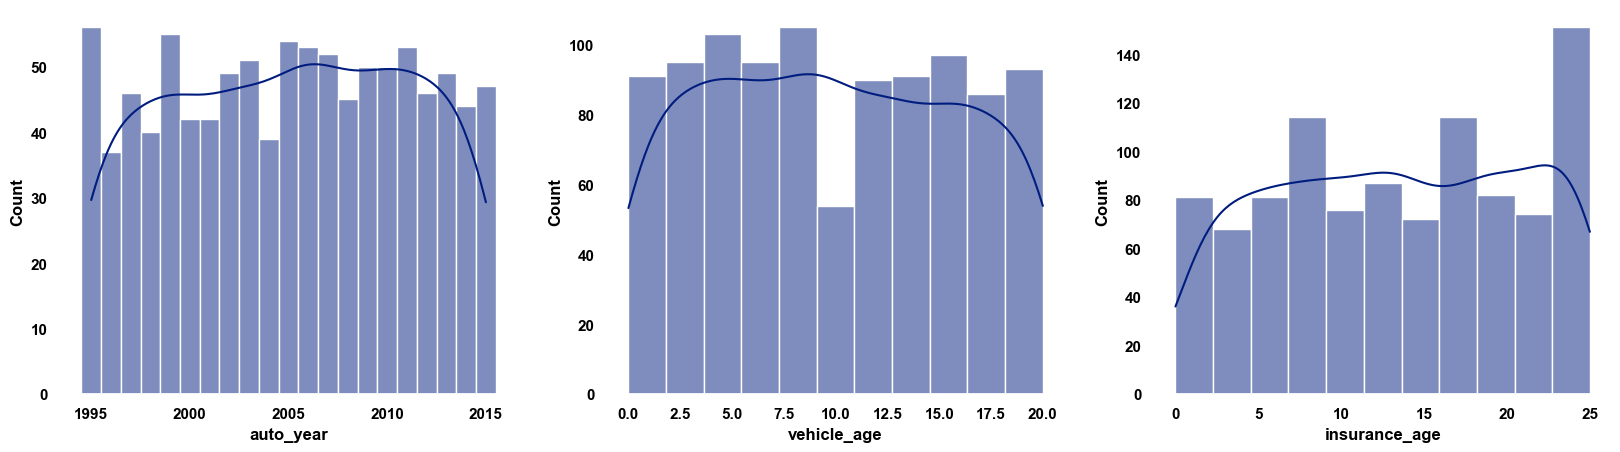

In [188]:
fig, axes = plt.subplots(ncols=3, nrows = 1, figsize=(20, 5))
for i, col in enumerate(['auto_year','vehicle_age','insurance_age']):
    sns.histplot(data=df,x=col,kde=True,ax=axes[i])
plt.show()


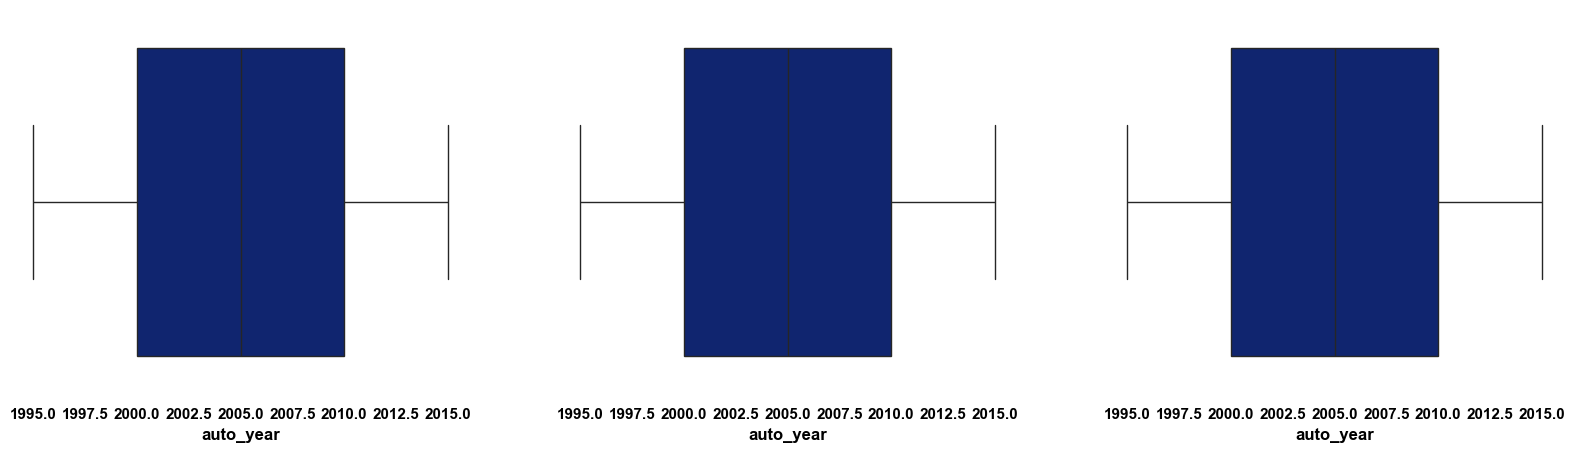

In [189]:
fig, axes = plt.subplots(ncols=3, nrows = 1, figsize=(20, 5))
for i, col in enumerate(['auto_year','vehicle_age','insurance_age']):
    sns.boxplot(data=df,x='auto_year',ax=axes[i])
plt.show()

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   months_as_customer            1000 non-null   int16         
 1   policy_bind_date              1000 non-null   datetime64[ns]
 2   policy_state                  1000 non-null   category      
 3   policy_deductable             1000 non-null   int16         
 4   insured_sex                   1000 non-null   category      
 5   insured_education_level       1000 non-null   category      
 6   insured_occupation            1000 non-null   category      
 7   insured_hobbies               1000 non-null   category      
 8   insured_relationship          1000 non-null   category      
 9   incident_date                 1000 non-null   datetime64[ns]
 10  incident_type                 1000 non-null   category      
 11  collision_type                1

## <span style="color:Aqua;"> Encoding Categorical Features:</span> 

In [191]:
df.sample(2)

months_as_customer policy_bind_date policy_state  policy_deductable  \
420                 208       2014-06-24           IN               1000   
339                 212       1990-04-29           IN               2000   

    insured_sex insured_education_level insured_occupation insured_hobbies  \
420      FEMALE                 College       tech-support           chess   
339        MALE                      MD    priv-house-serv     video-games   

    insured_relationship incident_date             incident_type  \
420              husband    2015-01-20  Single Vehicle Collision   
339            unmarried    2015-01-21   Multi-vehicle Collision   

      collision_type incident_severity authorities_contacted incident_state  \
420   Rear Collision      Major Damage             Ambulance             SC   
339  Front Collision        Total Loss                  Fire             NY   

    incident_city incident_hour_of_the_day number_of_vehicles_involved  \
420     Northbend                       18                           1   
339      Columbus                        0                           3   

    property_damage bodily_injuries witnesses police_report_available  \
420              NO               2         2                      NO   
339             YES               1         3                     YES   

      auto_make auto_year fraud_reported  age_boxcox  \
420  Volkswagen      1996              N      4.2853   
339      Suburu      1996              N      4.0772   

     policy_annual_premium_boxcox  total_claim_amount_boxcox  \
420                     1137.5961                145975.4196   
339                     1126.7627                103674.1880   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  \
420             -25912               -10688           114277.2016   
339               2624                 2624            95735.1132   

     insurance_age  vehicle_age  
420              1           19  
339             25           19

In [192]:
insured_sex_map = { 'FEMALE': 0,'MALE':1  }
property_damage_map = { 'NO':0, 'YES':1 }
police_report_available_map = { 'NO':0, 'YES':1 }
fraud_reported_map = { 'N':0, 'Y':1 }

In [193]:
df['insured_sex'] = pd.to_numeric(df['insured_sex'].map(insured_sex_map),errors='raise',downcast='integer')
df['property_damage'] = pd.to_numeric(df['property_damage'].map(property_damage_map),errors='raise',downcast='integer')
df['police_report_available'] = pd.to_numeric(df['police_report_available'].map(police_report_available_map),errors='raise',downcast='integer')
df['fraud_reported'] = pd.to_numeric(df['fraud_reported'].map(fraud_reported_map),errors='raise',downcast='integer')

In [194]:
policy_state = pd.get_dummies(df['policy_state'],dtype='int8')
insured_occupation = pd.get_dummies(df['insured_occupation'],dtype='int8')
insured_hobbies = pd.get_dummies(df['insured_hobbies'],dtype='int8')
insured_relationship = pd.get_dummies(df['insured_relationship'],dtype='int8')
incident_type = pd.get_dummies(df['incident_type'],dtype='int8')
collision_type = pd.get_dummies(df['collision_type'],dtype='int8')
authorities_contacted = pd.get_dummies(df['authorities_contacted'],dtype='int8')
incident_state = pd.get_dummies(df['incident_state'],dtype='int8')
incident_city = pd.get_dummies(df['incident_city'],dtype='int8')
auto_make = pd.get_dummies(df['auto_make'],dtype='int8')

en = LabelEncoder()
df['insured_education_level'] = en.fit_transform(df['insured_education_level']).astype('int8')

en1 = LabelEncoder()
df['incident_severity'] = en.fit_transform(df['incident_severity']).astype('int8')


df1= pd.concat([df,policy_state,insured_hobbies,insured_occupation,insured_relationship,incident_type,collision_type,
                authorities_contacted,incident_state,'incident_city',auto_make],axis=1)
df1 = df1.drop(['policy_state','insured_hobbies','insured_occupation','insured_relationship','incident_type','collision_type',
                'authorities_contacted','incident_state','incident_city','auto_make'],axis=1)

In [195]:
cols = ['incident_hour_of_the_day', 'number_of_vehicles_involved','bodily_injuries', 'witnesses', 'auto_year']

df1[cols] = df1[cols].apply(lambda x: pd.to_numeric(x, errors='coerce', downcast='integer'))

## <span style="color:Aqua;">Preparing the data afor modeling:</span>

In [3]:
df1 = pd.read_feather('clustered.feather')
df1.sample(3)

months_as_customer policy_bind_date  policy_deductable  insured_sex  \
545                 131       2013-07-04               1000            0   
646                 169       1998-12-11                500            1   
827                  76       2011-06-06               1000            0   

     insured_education_level incident_date  incident_severity  \
545                        0    2015-02-03                  0   
646                        2    2015-02-09                  2   
827                        4    2015-02-18                  2   

     incident_hour_of_the_day  number_of_vehicles_involved  property_damage  \
545                         5                            1                1   
646                         0                            3                0   
827                         6                            3                0   

     bodily_injuries  witnesses  police_report_available  auto_year  \
545                1          3                        0       2003   
646                2          3                        1       2004   
827                1          1                        1       1997   

     fraud_reported  age_boxcox  policy_annual_premium_boxcox  \
545               0      3.8331                      980.5632   
646               0      4.1141                     1621.1655   
827               0      3.5909                     1627.6026   

     total_claim_amount_boxcox  injury_claim_cube  property_claim_cube  \
545                162083.8806              12288               -31232   
646                164452.8972                  0                    0   
827                158216.5421             -15936               -26568   

     vehicle_claim_boxcox  insurance_age  vehicle_age  policy_state__IL  \
545           127060.9980              2           12                 0   
646           134413.3232             17           11                 0   
827           123990.2727              4           18                 0   

     policy_state__IN  policy_state__OH  insured_hobbies__base-jumping  \
545                 1                 0                              0   
646                 1                 0                              0   
827                 0                 1                              0   

     insured_hobbies__basketball  insured_hobbies__board-games  \
545                            0                             0   
646                            0                             0   
827                            0                             0   

     insured_hobbies__bungie-jumping  insured_hobbies__camping  \
545                                0                         0   
646                                0                         0   
827                                0                         0   

     insured_hobbies__chess  insured_hobbies__cross-fit  \
545                       0                           0   
646                       0                           0   
827                       0                           0   

     insured_hobbies__dancing  insured_hobbies__exercise  \
545                         0                          0   
646                         0                          0   
827                         0                          0   

     insured_hobbies__golf  insured_hobbies__hiking  \
545                      0                        0   
646                      0                        0   
827                      0                        0   

     insured_hobbies__kayaking  insured_hobbies__movies  \
545                          0                        0   
646                          0                        0   
827                          0                        0   

     insured_hobbies__paintball  insured_hobbies__polo  \
545                           1                      0   
646                           0                      0   
827                           1          

In [4]:
df1.drop_duplicates()

months_as_customer policy_bind_date  policy_deductable  insured_sex  \
0                   328       2014-10-17               1000            1   
1                   228       2006-06-27               2000            1   
2                   134       2000-09-06               2000            0   
3                   256       1990-05-25               2000            0   
4                   228       2014-06-06               1000            1   
..                  ...              ...                ...          ...   
995                   3       1991-07-16               1000            0   
996                 285       2014-01-05               1000            0   
997                 130       2003-02-17                500            0   
998                 458       2011-11-18               2000            1   
999                 456       1996-11-11               1000            0   

     insured_education_level incident_date  incident_severity  \
0                          4    2015-01-25                  0   
1                          4    2015-01-21                  1   
2                          6    2015-02-22                  1   
3                          6    2015-01-10                  0   
4                          0    2015-02-17                  1   
..                       ...           ...                ...   
995                        5    2015-02-22                  1   
996                        6    2015-01-24                  0   
997                        5    2015-01-23                  1   
998                        0    2015-02-26                  0   
999                        0    2015-02-26                  1   

     incident_hour_of_the_day  number_of_vehicles_involved  property_damage  \
0                           5                            1                1   
1                           8                            1                1   
2                           7                            3                0   
3                           5                            1                1   
4                          20                            1                0   
..                        ...                          ...              ...   
995                        20                            1                1   
996                        23                            1                1   
997                         4                            3                1   
998                         2                            1                1   
999                         6                            1                1   

     bodily_injuries  witnesses  police_report_available  auto_year  \
0                  1          2                        0       2004   
1                  0          0                        0       2007   
2                  2          3                        0       2007   
3                  1          2                        0       2014   
4                  0          1                        0       2009   
..               ...        ...                      ...        ...   
995                0          1                        0       2006   
996                2          3                        0       2015   
997                2          3                        1       1996   
998                0          1                        1       1998   
999                0          3                        0       2007   

     fraud_reported  age_boxcox  policy_annual_premium_boxcox  \
0                 1      4.4951                     1410.9388   
1                 1      4.3172                     1200.3887   
2                 0      3.8331                     1417.1946   
3                 1      4.2853                     1419.8054   
4                 0      4.3790                     1588.6789   
..              ...         ...                           ...   
995               0      4.1851                     13

In [5]:
x = df1.drop(['policy_bind_date','incident_date','fraud_reported'],axis=1)
y = df1[['fraud_reported']]

In [6]:
x.describe().T

count      mean      std      min      25%  \
months_as_customer      1000.0000  203.9540 115.1132   0.0000 115.7500   
policy_deductable       1000.0000 1136.0000 611.8647 500.0000 500.0000   
insured_sex             1000.0000    0.4630   0.4989   0.0000   0.0000   
insured_education_level 1000.0000    2.9660   1.9485   0.0000   1.0000   
incident_severity       1000.0000    1.1840   0.9397   0.0000   0.0000   
...                           ...       ...      ...      ...      ...   
auto_make__Saab         1000.0000    0.0800   0.2714   0.0000   0.0000   
auto_make__Suburu       1000.0000    0.0800   0.2714   0.0000   0.0000   
auto_make__Toyota       1000.0000    0.0700   0.2553   0.0000   0.0000   
auto_make__Volkswagen   1000.0000    0.0680   0.2519   0.0000   0.0000   
Cluster                 1000.0000    0.2300   0.4210   0.0000   0.0000   

                              50%       75%       max  
months_as_customer       199.5000  276.2500  479.0000  
policy_deductable       1000.0000 2000.0000 2000.0000  
insured_sex                0.0000    1.0000    1.0000  
insured_education_level    3.0000    5.0000    6.0000  
incident_severity          1.0000    2.0000    3.0000  
...                           ...       ...       ...  
auto_make__Saab            0.0000    0.0000    1.0000  
auto_make__Suburu          0.0000    0.0000    1.0000  
auto_make__Toyota          0.0000    0.0000    1.0000  
auto_make__Volkswagen      0.0000    0.0000    1.0000  
Cluster                    0.0000    0.0000    1.0000  

[104 rows x 8 columns]

In [7]:
y.describe()

fraud_reported
count       1000.0000
mean           0.2470
std            0.4315
min            0.0000
25%            0.0000
50%            0.0000
75%            0.0000
max            1.0000

In [8]:
y.value_counts()

fraud_reported
0                 753
1                 247
Name: count, dtype: int64

## <span style="color:Aqua;">Splitting data for train_test and resampling imbalanced data classess:</span>

In [13]:
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size=.3,random_state=42)
x_train = x_train.astype(float)

smote_tomek = SMOTETomek(random_state=42)
x_train, y_train = smote_tomek.fit_resample(x_train, y_train) 

In [14]:
print(x_train.shape,'----', y_train.shape)
print(x_test.shape,'----', y_test.shape)

(992, 104) ---- (992, 1)
(300, 104) ---- (300, 1)


## <span style="color:Aqua;">Normalizing / Scaling the data:</span>

In [15]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[continuous])
x_test_scaled = scaler.transform(x_test[continuous])

In [16]:
y_train, y_test = y_train.values.ravel(), y_test.values.ravel()

In [17]:
x_train_scaled_continuous = pd.DataFrame(x_train_scaled, columns=continuous)
x_test_scaled_continuous = pd.DataFrame(x_test_scaled, columns=continuous)

In [18]:
x_train_scaled_df = pd.concat([x_train_scaled_continuous.reset_index(drop=True), x_train.drop(continuous,axis=1).reset_index(drop=True)], axis=1)
x_test_scaled_df = pd.concat([x_test_scaled_continuous.reset_index(drop=True), x_test.drop(continuous,axis=1).reset_index(drop=True)], axis=1)

In [19]:
x_test_scaled_df.sample(2)

age_boxcox  policy_annual_premium_boxcox  total_claim_amount_boxcox  \
39      -0.2671                       -1.5522                     0.2452   
159      1.0462                        0.5735                     0.1773   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  \
39              0.8250              -0.2892                0.2685   
159             1.5146               1.4622               -0.0218   

     insurance_age  vehicle_age  auto_year  policy_deductable  \
39         -0.4943       0.9081    -0.9081             1.4269   
159        -1.8085       1.2618    -1.2618            -0.2941   

     months_as_customer  insured_sex  insured_education_level  \
39                  151            0                        4   
159                 280            1                        3   

     incident_severity  incident_hour_of_the_day  number_of_vehicles_involved  \
39                   1                        12                            3   
159                  1                        16                            1   

     property_damage  bodily_injuries  witnesses  police_report_available  \
39                 0                1          1                        0   
159                0                2          2                        0   

     policy_state__IL  policy_state__IN  policy_state__OH  \
39                  0                 0                 1   
159                 1                 0                 0   

     insured_hobbies__base-jumping  insured_hobbies__basketball  \
39                               0                            0   
159                              0                            0   

     insured_hobbies__board-games  insured_hobbies__bungie-jumping  \
39                              0                                0   
159                             0                                0   

     insured_hobbies__camping  insured_hobbies__chess  \
39                          0                       0   
159                         0                       0   

     insured_hobbies__cross-fit  insured_hobbies__dancing  \
39                            0                         0   
159                           0                         0   

     insured_hobbies__exercise  insured_hobbies__golf  \
39                           0                      0   
159                          0                      0   

     insured_hobbies__hiking  insured_hobbies__kayaking  \
39                         0                          1   
159                        0                          0   

     insured_hobbies__movies  insured_hobbies__paintball  \
39                         0                           0   
159                        0                           1   

     insured_hobbies__polo  insured_hobbies__reading  \
39                       0                         0   
159                      0                         0   

     insured_hobbies__skydiving  insured_hobbies__sleeping  \
39                            0                          0   
159                           0                          0   

     insured_hobbies__video-games  insured_hobbies__yachting  \
39                              0                          0   
159                             0                          0   

     insured_occ__adm-clerical  insured_occ__armed-forces  \
39                           1                          0   
159                          0                          0   

     insured_occ__craft-repair  insured_occ__exec-managerial  \
39                           0                             0   
159                          0                             0   

     insured_occ__farming-fishing  insured_occ__handlers-cleaners  \
39                              0                               0   
159                             0                               0   

     insured_occ__machine-op-inspct  insured_occ__other-service  \
39             

In [20]:
x_train_scaled_df.sample(2)

age_boxcox  policy_annual_premium_boxcox  total_claim_amount_boxcox  \
73       1.9258                       -1.0571                     1.8194   
299      0.9491                       -0.9641                    -2.0598   

     injury_claim_cube  property_claim_cube  vehicle_claim_boxcox  \
73             -1.5795               0.7667                2.1451   
299             1.7550               1.7048               -2.0760   

     insurance_age  vehicle_age  auto_year  policy_deductable  \
73          0.2358       0.5545    -0.5545            -1.1545   
299        -1.6624       0.5545    -0.5545            -0.2941   

     months_as_customer  insured_sex  insured_education_level  \
73             398.0000       0.0000                   0.0000   
299            308.0000       0.0000                   0.0000   

     incident_severity  incident_hour_of_the_day  number_of_vehicles_involved  \
73              0.0000                   18.0000                       1.0000   
299             1.0000                    7.0000                       1.0000   

     property_damage  bodily_injuries  witnesses  police_report_available  \
73            1.0000           2.0000     1.0000                   0.0000   
299           1.0000           1.0000     1.0000                   1.0000   

     policy_state__IL  policy_state__IN  policy_state__OH  \
73             0.0000            0.0000            1.0000   
299            0.0000            0.0000            1.0000   

     insured_hobbies__base-jumping  insured_hobbies__basketball  \
73                          0.0000                       0.0000   
299                         0.0000                       0.0000   

     insured_hobbies__board-games  insured_hobbies__bungie-jumping  \
73                         0.0000                           0.0000   
299                        0.0000                           0.0000   

     insured_hobbies__camping  insured_hobbies__chess  \
73                     0.0000                  0.0000   
299                    0.0000                  0.0000   

     insured_hobbies__cross-fit  insured_hobbies__dancing  \
73                       1.0000                    0.0000   
299                      0.0000                    0.0000   

     insured_hobbies__exercise  insured_hobbies__golf  \
73                      0.0000                 0.0000   
299                     0.0000                 0.0000   

     insured_hobbies__hiking  insured_hobbies__kayaking  \
73                    0.0000                     0.0000   
299                   0.0000                     0.0000   

     insured_hobbies__movies  insured_hobbies__paintball  \
73                    0.0000                      0.0000   
299                   1.0000                      0.0000   

     insured_hobbies__polo  insured_hobbies__reading  \
73                  0.0000                    0.0000   
299                 0.0000                    0.0000   

     insured_hobbies__skydiving  insured_hobbies__sleeping  \
73                       0.0000                     0.0000   
299                      0.0000                     0.0000   

     insured_hobbies__video-games  insured_hobbies__yachting  \
73                         0.0000                     0.0000   
299                        0.0000                     0.0000   

     insured_occ__adm-clerical  insured_occ__armed-forces  \
73                      0.0000                     0.0000   
299                     0.0000                     0.0000   

     insured_occ__craft-repair  insured_occ__exec-managerial  \
73                      0.0000                        1.0000   
299                     1.0000                        0.0000   

     insured_occ__farming-fishing  insured_occ__handlers-cleaners  \
73                         0.0000                          0.0000   
299                        0.0000                          0.0000   

     insured_occ__machine-op-inspct  insured_occ__other-service  \
73             

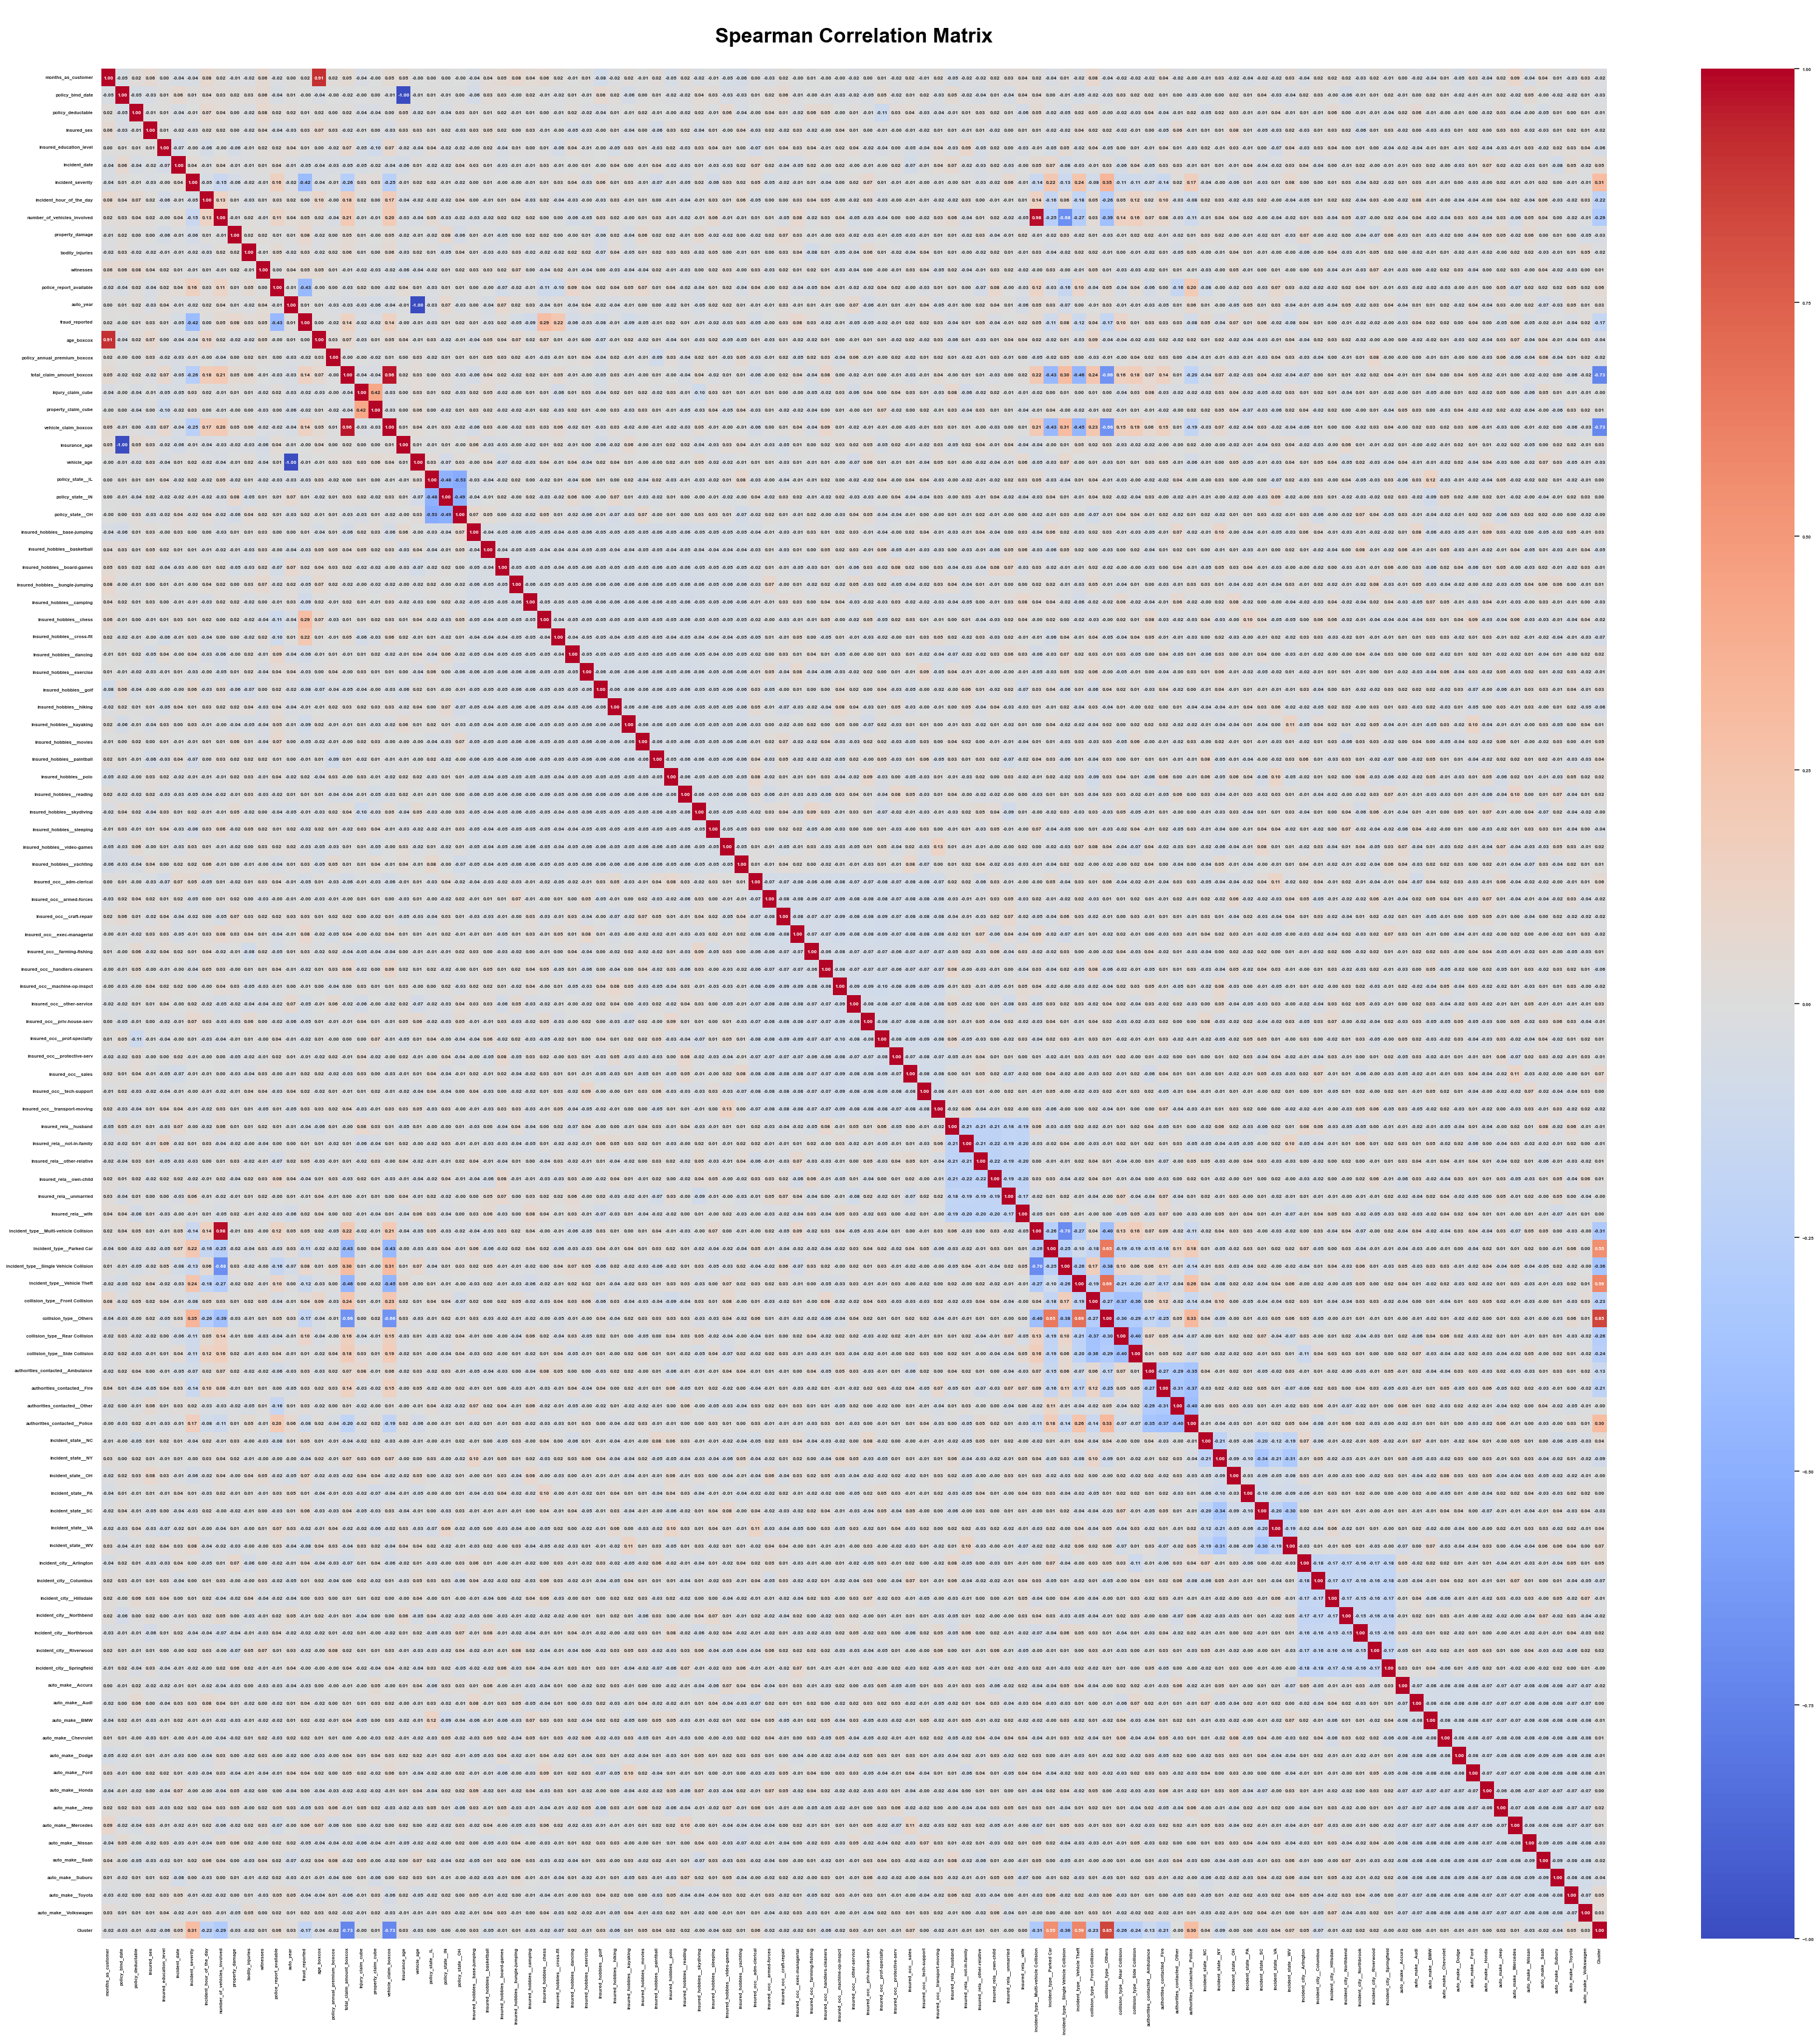

In [21]:
plt.figure(figsize=(40,40))
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=.5, color_codes=True, rc=None)

cor_col = df1
correlation_matrix = cor_col.corr(method='spearman')
sns.heatmap(correlation_matrix,annot=True,fmt='.2f',cmap='coolwarm')
plt.title('\nSpearman Correlation Matrix\n',fontdict={'fontsize':24,'color':'black','fontweight':'bold'})

plt.show()
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [22]:
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

## <span style="color:Aqua;">Training all the model:</span>

#### <span style="color:Khaki;">Defing the function to train and evaluate the model:</span>

In [23]:
def evaluate_model(model, x_train, y_train, x_test, y_test, color_positive='\033[92m', reset_color='\033[0m'):
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    y_preds_train = model.predict(x_train)

    print(f'{color_positive}Accuracy Test {reset_color} - {accuracy_score(y_test, y_preds)}')
    print(f'{color_positive}Accuracy Train{reset_color} - {accuracy_score(y_train, y_preds_train)}\n')

    print(f'{color_positive}Precision Test {reset_color} - {precision_score(y_test, y_preds, average="weighted")}')
    print(f'{color_positive}Precision Train{reset_color} - {precision_score(y_train, y_preds_train, average="weighted")}\n')

    print(f'{color_positive}Recall Test {reset_color} - {recall_score(y_test, y_preds, average="weighted")}')
    print(f'{color_positive}Recall Train{reset_color} - {recall_score(y_train, y_preds_train, average="weighted")}\n')

    print(f'{color_positive}F1_score Test {reset_color} - {f1_score(y_test, y_preds, average="weighted")}')
    print(f'{color_positive}F1_score Train{reset_color} - {f1_score(y_train, y_preds_train, average="weighted")}\n')
    
    print(f"{color_positive}Confusion Matrix Test {reset_color} -- \n{confusion_matrix(y_test, y_preds)}")
    print(f'{color_positive}Confusion Matrix Train{reset_color} -- \n{confusion_matrix(y_train, y_preds_train)}\n')

    print(f'{color_positive}Classification Report Test{reset_color}\n{classification_report(y_test, y_preds)}')
    print(f'{color_positive}Classification Report Train{reset_color}\n{classification_report(y_train, y_preds_train)}')
    
    print(f'{color_positive}Balanced Accuracy Test {reset_color} - {balanced_accuracy_score(y_test, y_preds)}')
    print(f'{color_positive}Balanced Accuracy Train{reset_color} - {balanced_accuracy_score(y_train, y_preds_train)}\n')

    cm = confusion_matrix(y_test, y_preds)
    specificity = np.diag(cm) / np.sum(cm, axis=1)
    print(f'{color_positive}Specificity Test{reset_color} - {specificity.mean()}\n')

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)[:, 1]  # Probability estimates for the positive class
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve for Logistic Regression')
        plt.legend(loc="lower right")
        plt.show()

    print('-'*40)

In [24]:
from sklearn.linear_model import LogisticRegression

/home/san/mnt/F/Technology/Python Project/Capstone/Insurance_Analytics_Prediction/Insurance/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Test  - 0.8233333333333334
Accuracy Train - 0.9032258064516129

Precision Test  - 0.8387554381866504
Precision Train - 0.9037575501033815

Recall Test  - 0.8233333333333334
Recall Train - 0.9032258064516129

F1_score Test  - 0.8282672863992734
F1_score Train - 0.9031939333563747

Confusion Matrix Test  -- 
[[185  35]
 [ 18  62]]
Confusion Matrix Train -- 
[[439  57]
 [ 39 457]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       220
           1       0.64      0.78      0.70        80

    accuracy                           0.82       300
   macro avg       0.78      0.81      0.79       300
weighted avg       0.84      0.82      0.83       300

Classification Report Train
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       496
           1       0.89      0.92      0.90       496

    accuracy                           0.90       992
   macro 

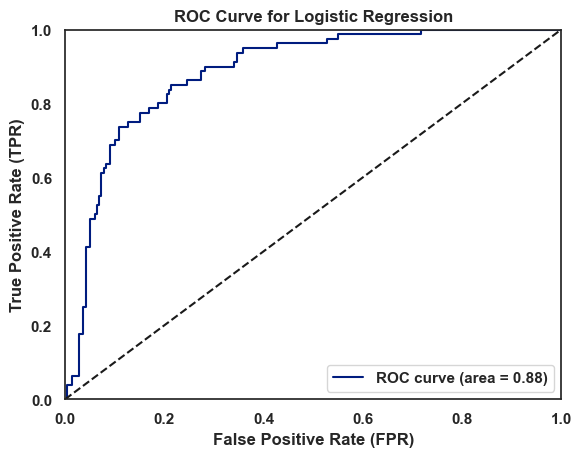

----------------------------------------


In [25]:
Linear_Model = LogisticRegression(random_state=42)
evaluate_model(Linear_Model, x_train_scaled_df, y_train, x_test_scaled_df, y_test)

Accuracy Test  - 0.81
Accuracy Train - 1.0

Precision Test  - 0.8031746031746032
Precision Train - 1.0

Recall Test  - 0.81
Recall Train - 1.0

F1_score Test  - 0.8053036503519398
F1_score Train - 1.0

Confusion Matrix Test  -- 
[[197  23]
 [ 34  46]]
Confusion Matrix Train -- 
[[496   0]
 [  0 496]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       220
           1       0.67      0.57      0.62        80

    accuracy                           0.81       300
   macro avg       0.76      0.74      0.75       300
weighted avg       0.80      0.81      0.81       300

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00       496

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00

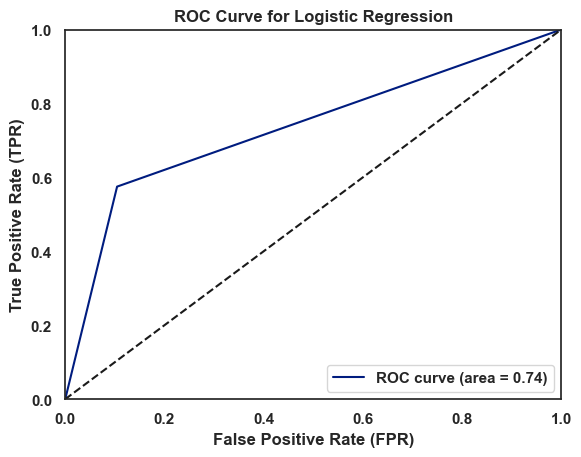

----------------------------------------


In [26]:
DT_Classifier = DecisionTreeClassifier(random_state=42)
evaluate_model(DT_Classifier, x_train_scaled_df, y_train, x_test_scaled_df, y_test)

                           Feature  Importance
13    policy_annual_premium_boxcox      0.3630
28          insured_hobbies__chess      0.1639
29      insured_hobbies__cross-fit      0.1266
19                     vehicle_age      0.1126
56   insured_occ__transport-moving      0.0161
..                             ...         ...
97             auto_make__Mercedes      0.0000
99                 auto_make__Saab      0.0000
100              auto_make__Suburu      0.0000
101              auto_make__Toyota      0.0000
103                        Cluster      0.0000

[104 rows x 2 columns]


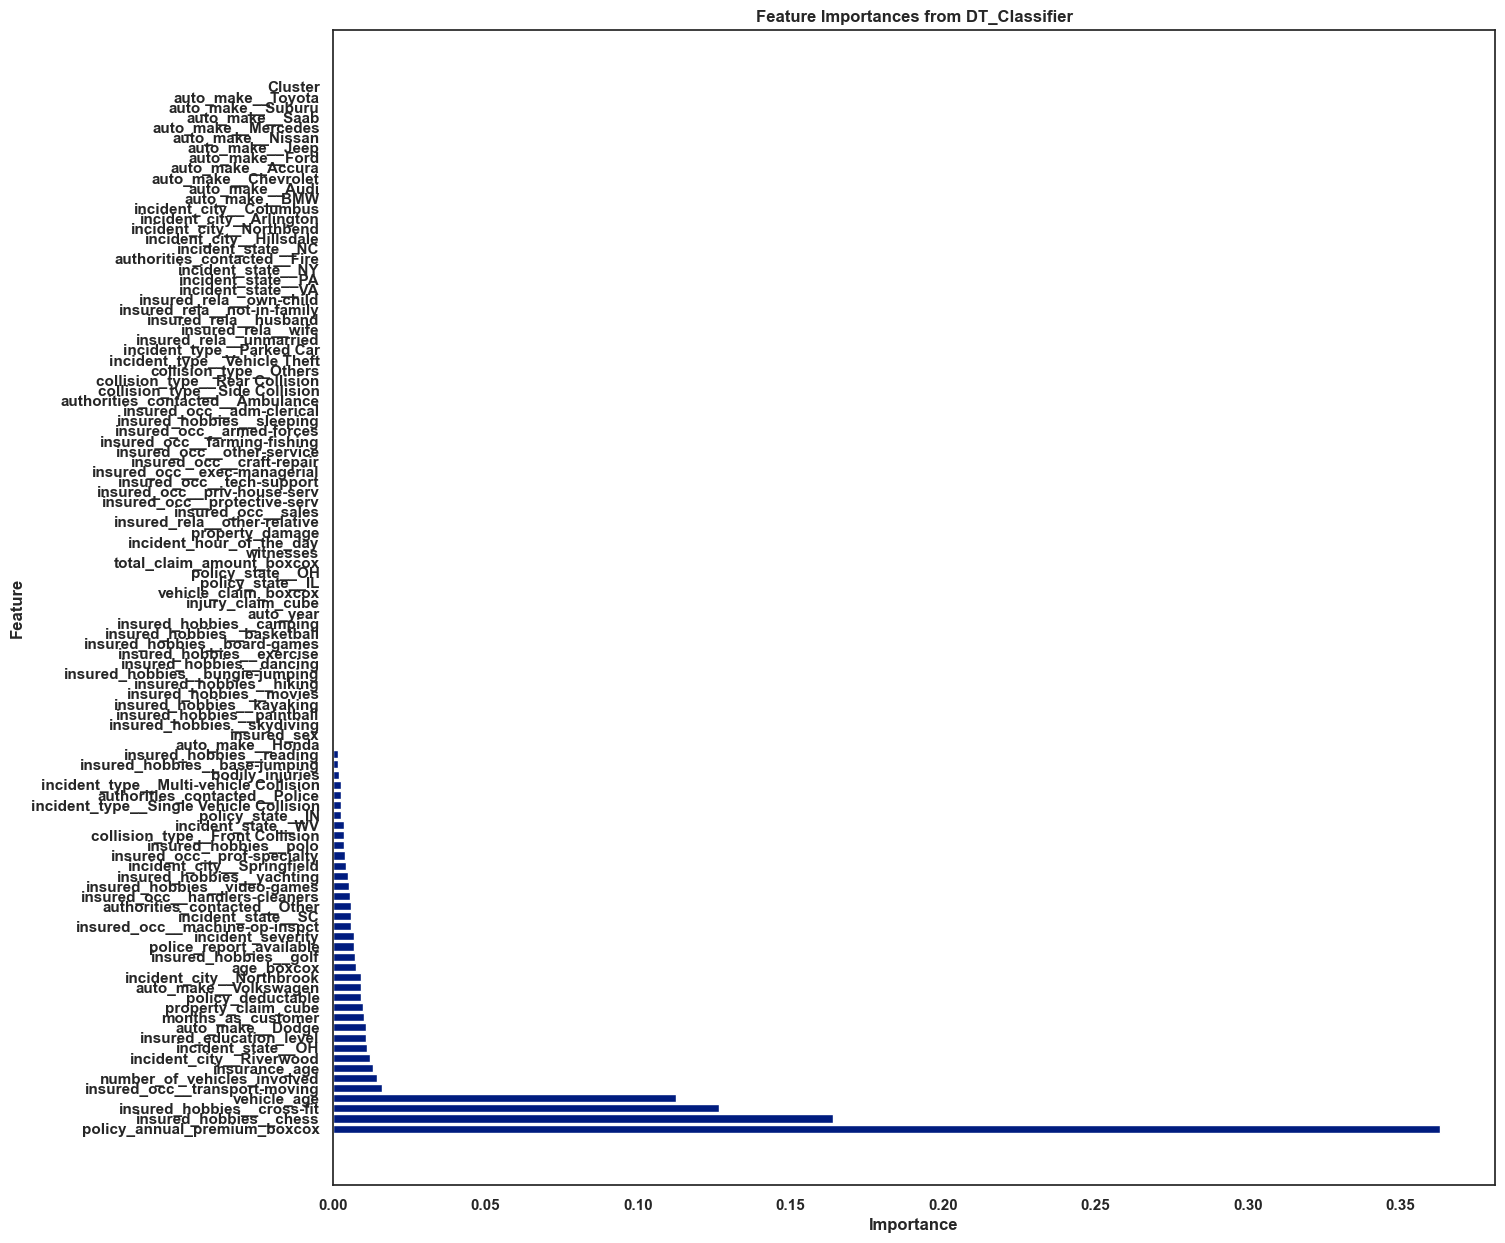

In [27]:
feature_importances = DT_Classifier.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(15, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from DT_Classifier')
plt.show()

Accuracy Test  - 0.8233333333333334
Accuracy Train - 1.0

Precision Test  - 0.8174268910751551
Precision Train - 1.0

Recall Test  - 0.8233333333333334
Recall Train - 1.0

F1_score Test  - 0.8079198143484916
F1_score Train - 1.0

Confusion Matrix Test  -- 
[[209  11]
 [ 42  38]]
Confusion Matrix Train -- 
[[496   0]
 [  0 496]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       220
           1       0.78      0.47      0.59        80

    accuracy                           0.82       300
   macro avg       0.80      0.71      0.74       300
weighted avg       0.82      0.82      0.81       300

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00       496

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg   

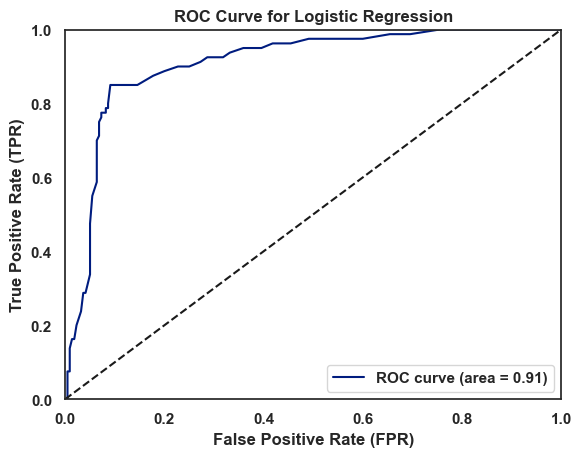

----------------------------------------


In [28]:
RF_Classifier = RandomForestClassifier(random_state=33,n_jobs=-1)
evaluate_model(RF_Classifier,  x_train_scaled_df, y_train, x_test_scaled_df, y_test)

                         Feature  Importance
13  policy_annual_premium_boxcox      0.1434
19                   vehicle_age      0.1125
28                         chess      0.0486
29                     cross-fit      0.0323
65      Single Vehicle Collision      0.0306
..                           ...         ...
24                    basketball      0.0011
96                          Jeep      0.0011
35                        movies      0.0010
40                      sleeping      0.0010
42                      yachting      0.0010

[103 rows x 2 columns]


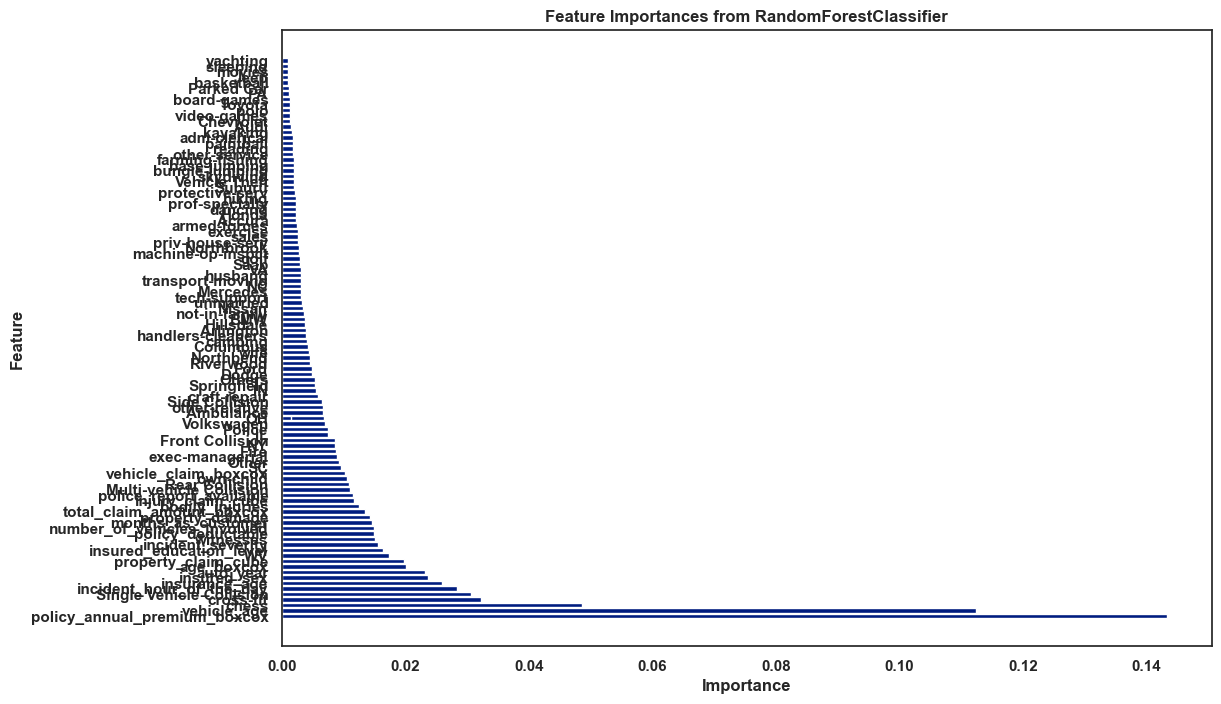

In [191]:
feature_importances = RF_Classifier.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForestClassifier')
plt.show()


Accuracy Test  - 0.89
Accuracy Train - 0.9868951612903226

Precision Test  - 0.8895813047711784
Precision Train - 0.9869129740210644

Recall Test  - 0.89
Recall Train - 0.9868951612903226

F1_score Test  - 0.8897788046036025
F1_score Train - 0.9868950414356921

Confusion Matrix Test  -- 
[[204  16]
 [ 17  63]]
Confusion Matrix Train -- 
[[491   5]
 [  8 488]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       220
           1       0.80      0.79      0.79        80

    accuracy                           0.89       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.89      0.89      0.89       300

Classification Report Train
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       496
           1       0.99      0.98      0.99       496

    accuracy                           0.99       992
   macro avg       0.99      0.99    

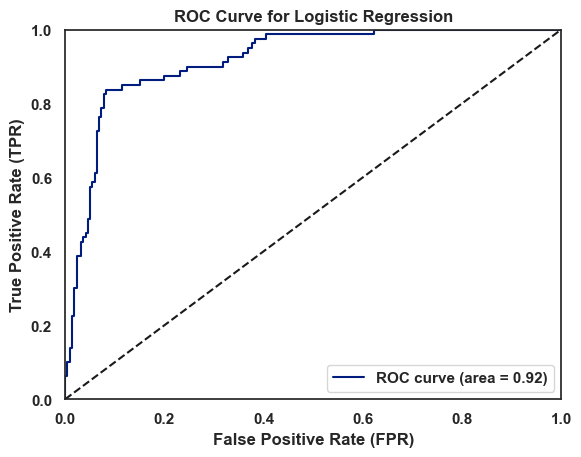

----------------------------------------


In [29]:
GB_Classifier = GradientBoostingClassifier(random_state=33)
evaluate_model(GB_Classifier, x_train_scaled_df, y_train, x_test_scaled_df, y_test)

                         Feature  Importance
13  policy_annual_premium_boxcox      0.3667
19                   vehicle_age      0.1863
28                         chess      0.1665
29                     cross-fit      0.1222
16           property_claim_cube      0.0115
..                           ...         ...
77                            OH      0.0000
85                     Northbend      0.0000
80                            VA      0.0000
91                           BMW      0.0000
96                          Jeep      0.0000

[103 rows x 2 columns]


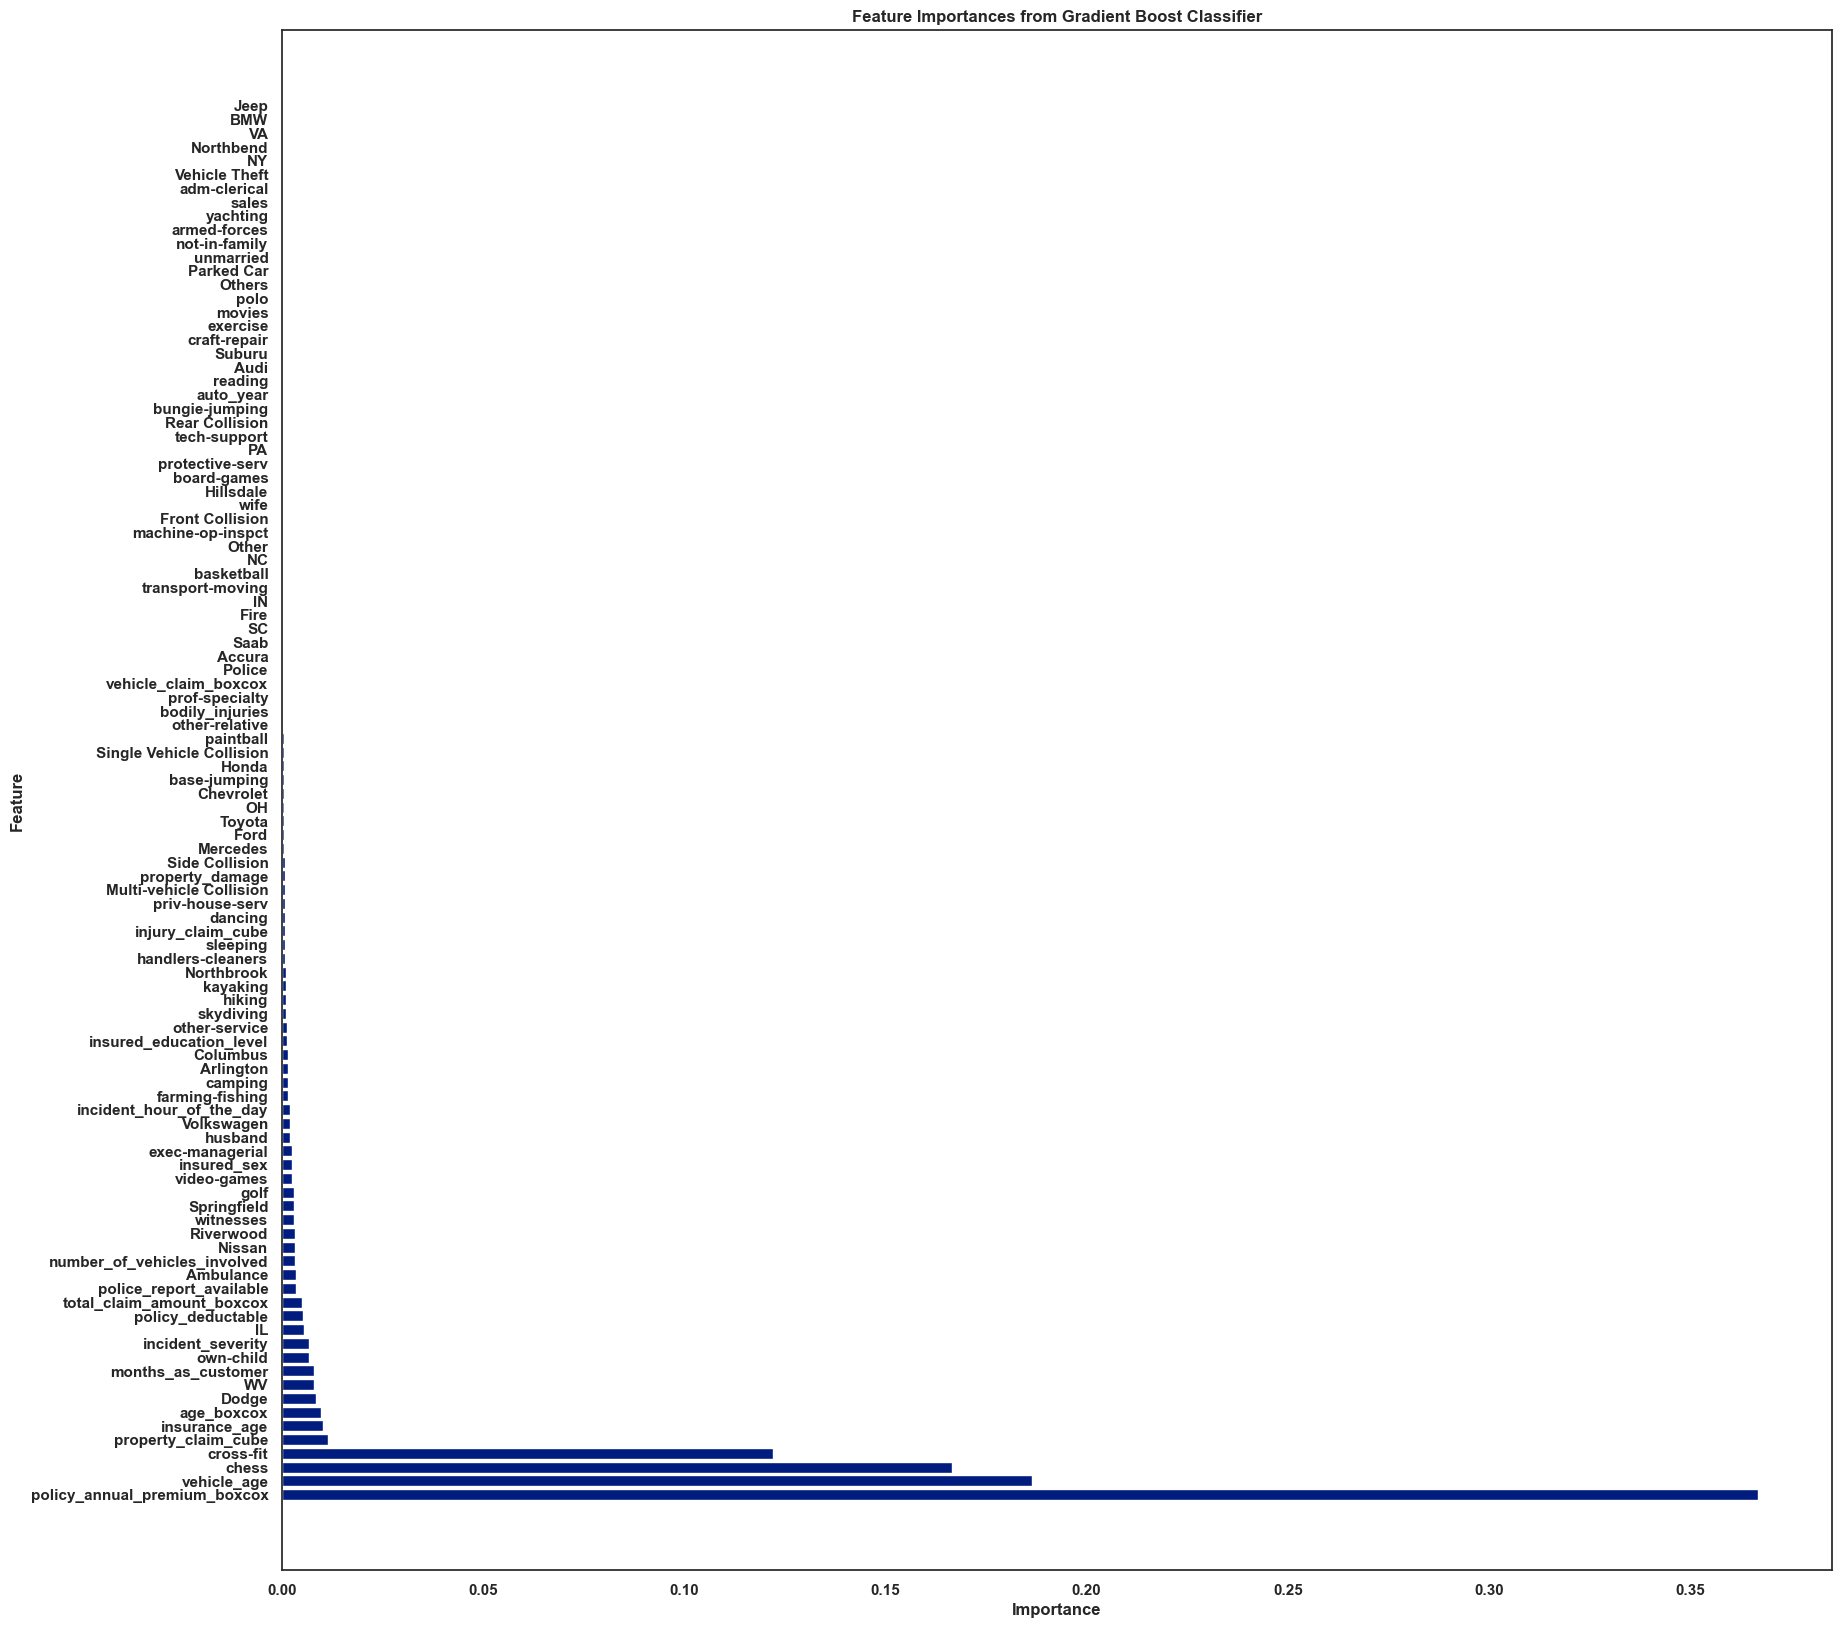

In [193]:
feature_importances = GB_Classifier.feature_importances_
# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(20, 20))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boost Classifier')
plt.show()


Accuracy Test  - 0.8766666666666667
Accuracy Train - 1.0

Precision Test  - 0.8753557354454216
Precision Train - 1.0

Recall Test  - 0.8766666666666667
Recall Train - 1.0

F1_score Test  - 0.8759059299410984
F1_score Train - 1.0

Confusion Matrix Test  -- 
[[203  17]
 [ 20  60]]
Confusion Matrix Train -- 
[[496   0]
 [  0 496]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       220
           1       0.78      0.75      0.76        80

    accuracy                           0.88       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.88      0.88      0.88       300

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00       496

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg   

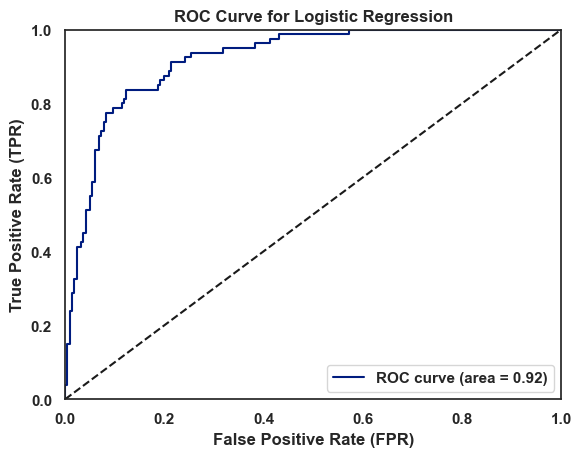

----------------------------------------


In [30]:
HGB_Classifier = HistGradientBoostingClassifier(random_state=33)
evaluate_model(HGB_Classifier, x_train_scaled_df, y_train, x_test_scaled_df, y_test)

Accuracy Test  - 0.8666666666666667
Accuracy Train - 1.0

Precision Test  - 0.8641074703021606
Precision Train - 1.0

Recall Test  - 0.8666666666666667
Recall Train - 1.0

F1_score Test  - 0.8649661250558112
F1_score Train - 1.0

Confusion Matrix Test  -- 
[[203  17]
 [ 23  57]]
Confusion Matrix Train -- 
[[496   0]
 [  0 496]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       220
           1       0.77      0.71      0.74        80

    accuracy                           0.87       300
   macro avg       0.83      0.82      0.83       300
weighted avg       0.86      0.87      0.86       300

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00       496

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg   

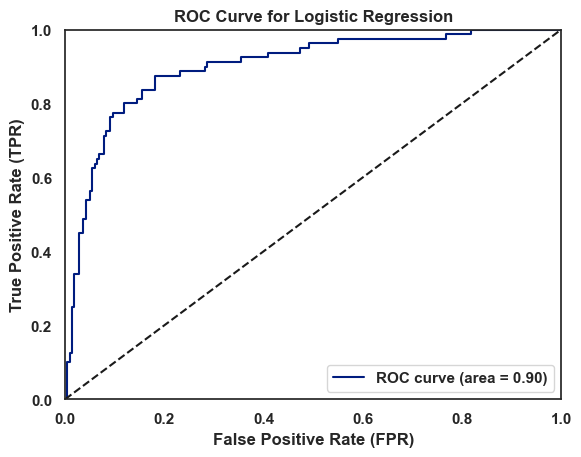

----------------------------------------


In [31]:
xgb_Classifier = xg.XGBClassifier(random_state=33)
evaluate_model(xgb_Classifier, x_train_scaled_df.values, y_train, x_test_scaled_df.values, y_test)

                          Feature  Importance
19                    vehicle_age      0.1758
28                          chess      0.1183
13   policy_annual_premium_boxcox      0.0722
29                      cross-fit      0.0685
93                          Dodge      0.0333
..                            ...         ...
90                           Audi      0.0000
97                       Mercedes      0.0000
96                           Jeep      0.0000
100                        Suburu      0.0000
101                        Toyota      0.0000

[103 rows x 2 columns]


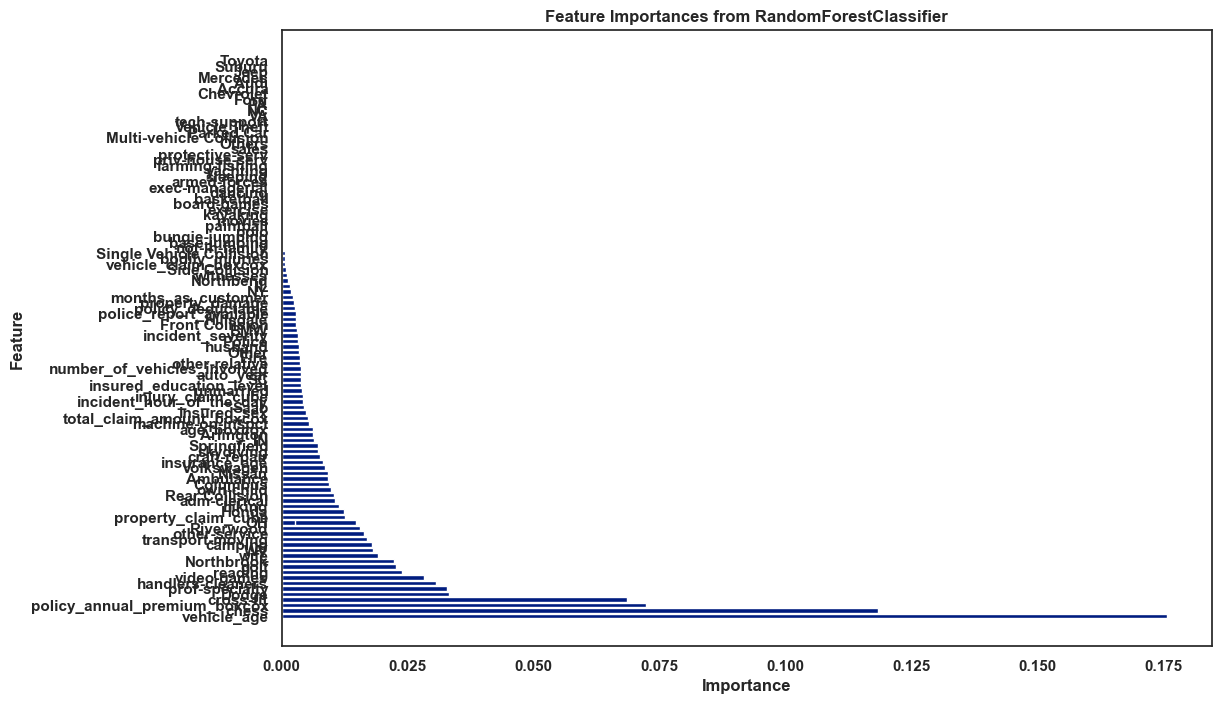

In [198]:
# Get feature importances
feature_importances = xgb_Classifier.feature_importances_

# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForestClassifier')
plt.show()

Accuracy Test  - 0.8466666666666667
Accuracy Train - 1.0

Precision Test  - 0.8413888888888889
Precision Train - 1.0

Recall Test  - 0.8466666666666667
Recall Train - 1.0

F1_score Test  - 0.839047619047619
F1_score Train - 1.0

Confusion Matrix Test  -- 
[[207  13]
 [ 33  47]]
Confusion Matrix Train -- 
[[496   0]
 [  0 496]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       220
           1       0.78      0.59      0.67        80

    accuracy                           0.85       300
   macro avg       0.82      0.76      0.79       300
weighted avg       0.84      0.85      0.84       300

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00       496

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg    

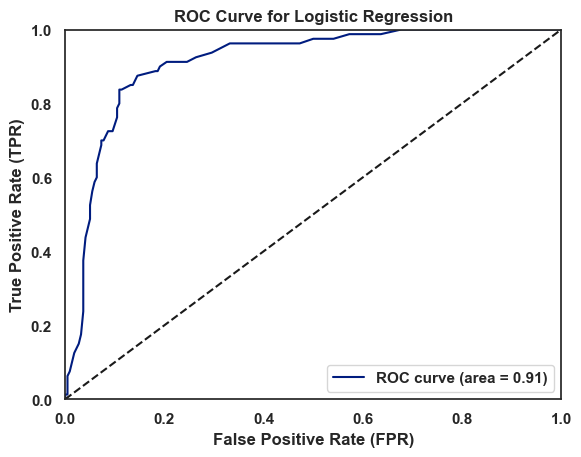

----------------------------------------


In [32]:
ET_Classifier =ExtraTreesClassifier(random_state=33,n_jobs=-1)
evaluate_model(ET_Classifier,  x_train_scaled_df, y_train, x_test_scaled_df, y_test)

                         Feature  Importance
19                   vehicle_age      0.1598
13  policy_annual_premium_boxcox      0.1230
28                         chess      0.0418
29                     cross-fit      0.0288
20                            IL      0.0170
..                           ...         ...
25                   board-games      0.0023
42                      yachting      0.0021
35                        movies      0.0020
78                            PA      0.0020
24                    basketball      0.0016

[103 rows x 2 columns]


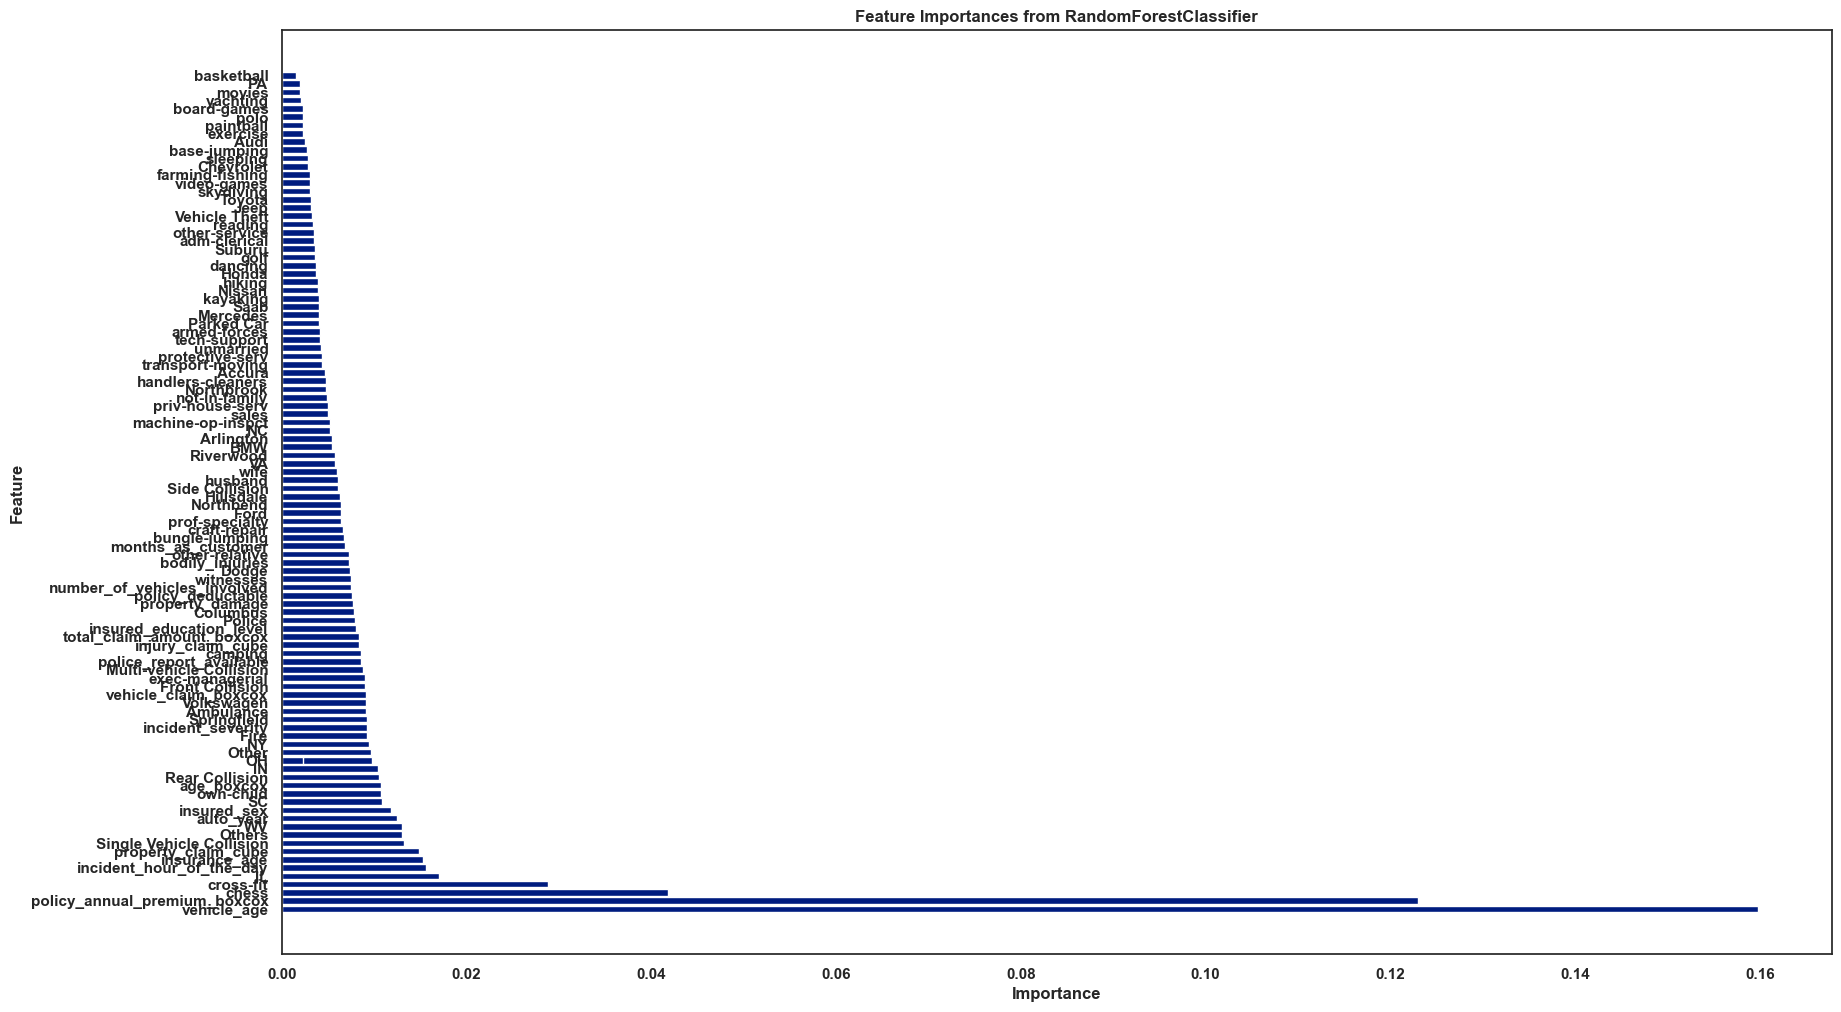

In [38]:
# Get feature importances
feature_importances = ET_Classifier.feature_importances_

# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(20, 12))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForestClassifier')
plt.show()

Accuracy Test  - 0.89
Accuracy Train - 0.9475806451612904

Precision Test  - 0.8926402188782488
Precision Train - 0.9477626506612014

Recall Test  - 0.89
Recall Train - 0.9475806451612904

F1_score Test  - 0.8910344827586205
F1_score Train - 0.9475753177961795

Confusion Matrix Test  -- 
[[201  19]
 [ 14  66]]
Confusion Matrix Train -- 
[[465  31]
 [ 21 475]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       220
           1       0.78      0.82      0.80        80

    accuracy                           0.89       300
   macro avg       0.86      0.87      0.86       300
weighted avg       0.89      0.89      0.89       300

Classification Report Train
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       496
           1       0.94      0.96      0.95       496

    accuracy                           0.95       992
   macro avg       0.95      0.95    

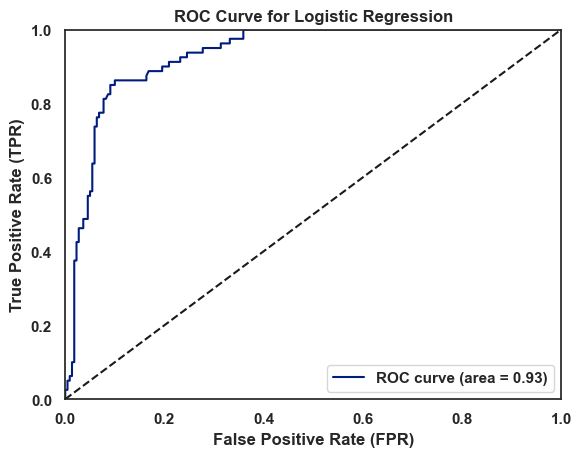

----------------------------------------


In [33]:
ADA_Classifier =AdaBoostClassifier(algorithm='SAMME',random_state=42,)
evaluate_model(ADA_Classifier,  x_train_scaled_df, y_train, x_test_scaled_df, y_test)


                          Feature  Importance
19                    vehicle_age      0.2044
13   policy_annual_premium_boxcox      0.1208
29     insured_hobbies__cross-fit      0.1046
28         insured_hobbies__chess      0.1037
12                     age_boxcox      0.0491
..                            ...         ...
99                auto_make__Saab      0.0000
100             auto_make__Suburu      0.0000
101             auto_make__Toyota      0.0000
102         auto_make__Volkswagen      0.0000
103                       Cluster      0.0000

[104 rows x 2 columns]


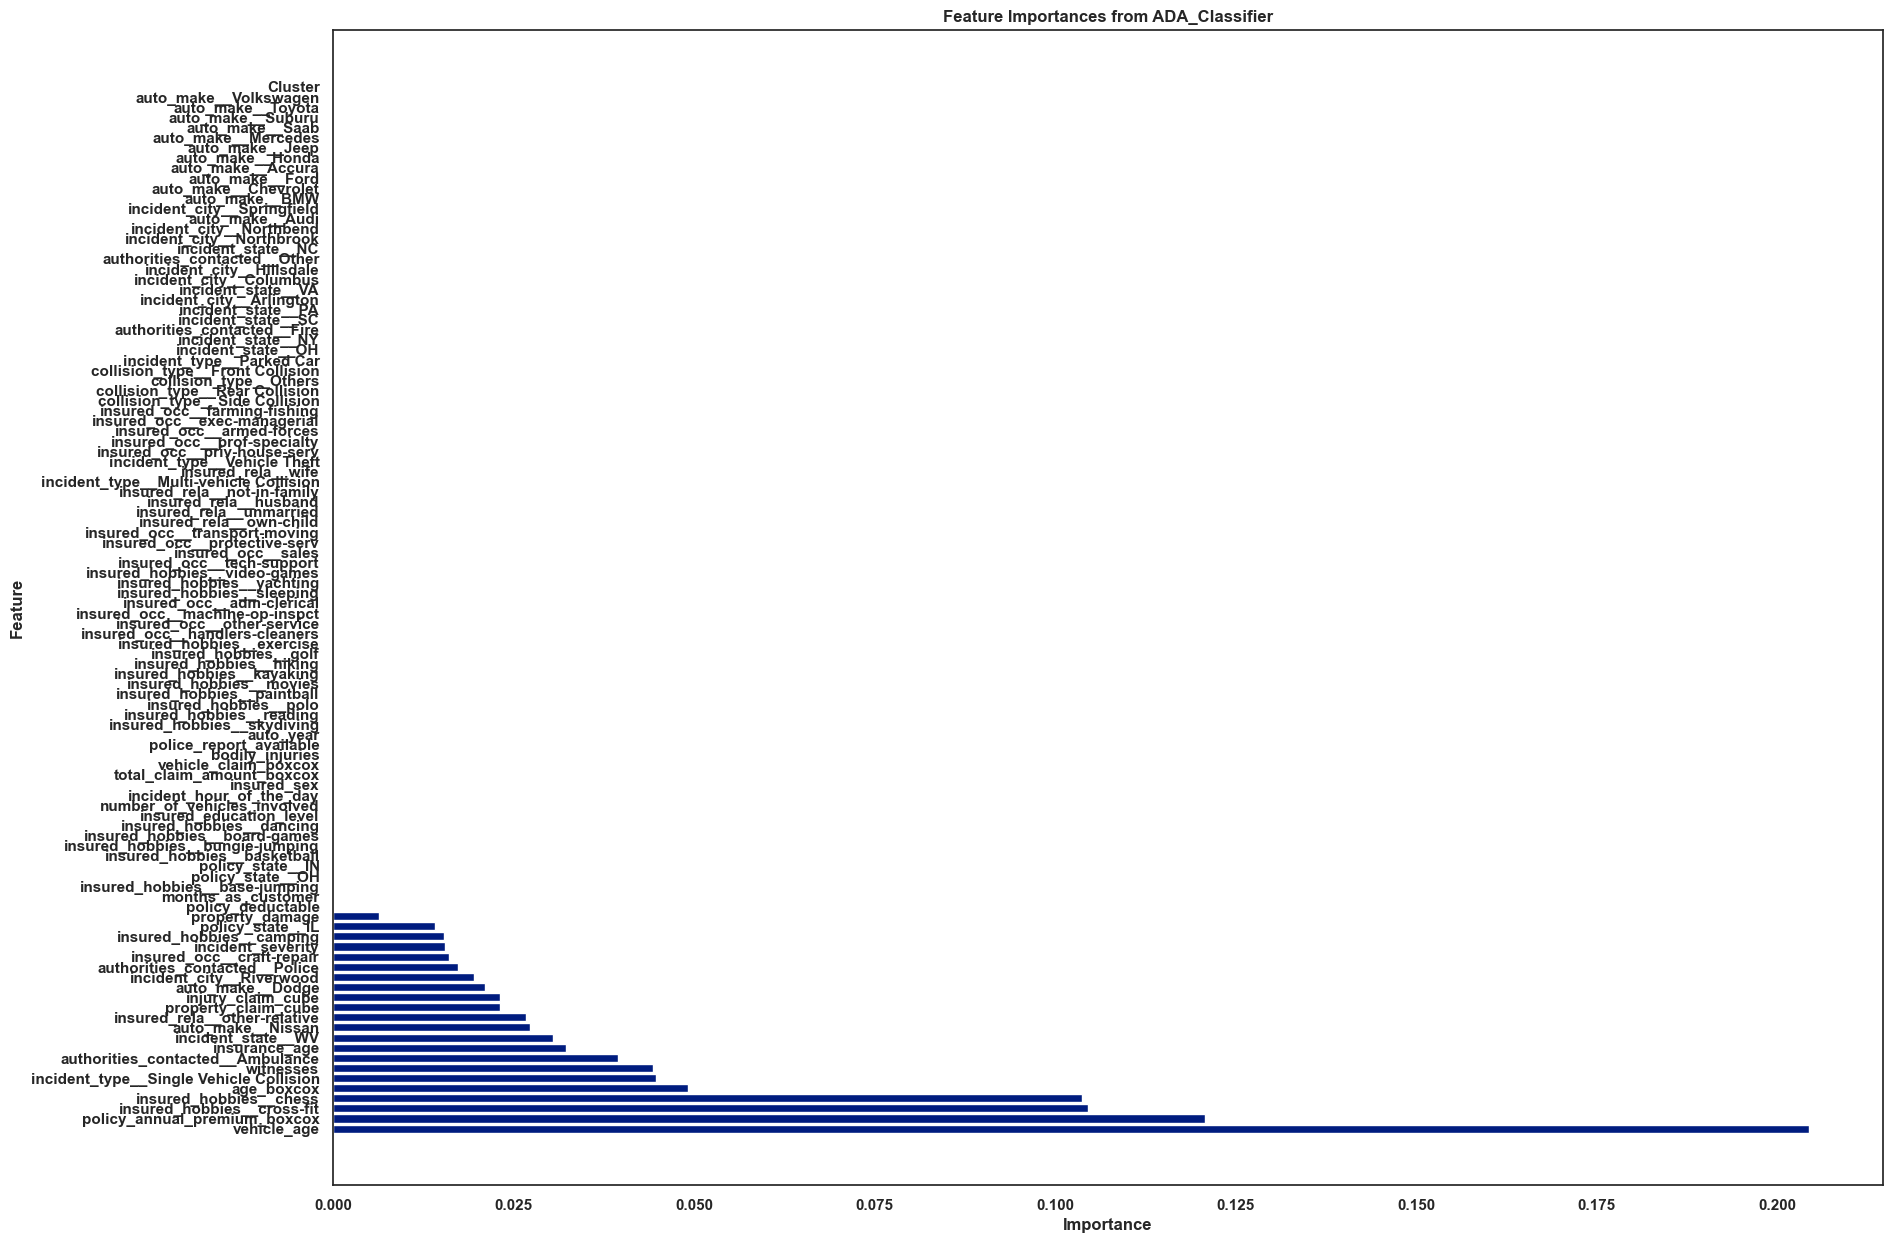

In [34]:
# Get feature importances
feature_importances = ADA_Classifier.feature_importances_

# Map feature importances to feature names
feature_names =  x_train.columns
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

# Plot feature importances
plt.figure(figsize=(20, 15))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from ADA_Classifier')
plt.show()

Accuracy Test  - 0.87
Accuracy Train - 0.9889112903225806

Precision Test  - 0.8672500150865969
Precision Train - 0.9889291768120418

Recall Test  - 0.87
Recall Train - 0.9889112903225806

F1_score Test  - 0.8680440408825723
F1_score Train - 0.988911188907124

Confusion Matrix Test  -- 
[[204  16]
 [ 23  57]]
Confusion Matrix Train -- 
[[492   4]
 [  7 489]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       220
           1       0.78      0.71      0.75        80

    accuracy                           0.87       300
   macro avg       0.84      0.82      0.83       300
weighted avg       0.87      0.87      0.87       300

Classification Report Train
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       496
           1       0.99      0.99      0.99       496

    accuracy                           0.99       992
   macro avg       0.99      0.99     

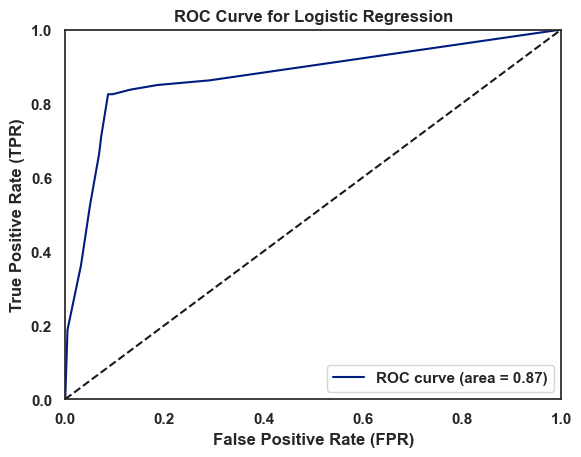

----------------------------------------


In [35]:
Bagging_Classifier = BaggingClassifier(n_jobs=-1,random_state=42,)
evaluate_model(Bagging_Classifier,  x_train_scaled_df, y_train, x_test_scaled_df, y_test)


In [36]:
params = {'n_neighbors' :range(1,30)}

KNN_grid_model = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=3, scoring='accuracy',verbose=3, n_jobs=1,error_score='raise')

KNN_grid_model.fit(x_train_scaled_df,y_train)




Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV 1/3] END .....................n_neighbors=1;, score=0.574 total time=   0.1s
[CV 2/3] END .....................n_neighbors=1;, score=0.598 total time=   0.0s
[CV 3/3] END .....................n_neighbors=1;, score=0.603 total time=   0.0s
[CV 1/3] END .....................n_neighbors=2;, score=0.541 total time=   0.0s
[CV 2/3] END .....................n_neighbors=2;, score=0.589 total time=   0.0s
[CV 3/3] END .....................n_neighbors=2;, score=0.552 total time=   0.0s
[CV 1/3] END .....................n_neighbors=3;, score=0.550 total time=   0.0s
[CV 2/3] END .....................n_neighbors=3;, score=0.568 total time=   0.0s
[CV 3/3] END .....................n_neighbors=3;, score=0.576 total time=   0.0s
[CV 1/3] END .....................n_neighbors=4;, score=0.529 total time=   0.0s
[CV 2/3] END .....................n_neighbors=4;, score=0.553 total time=   0.0s
[CV 3/3] END .....................n_neighbors=4;

GridSearchCV(cv=3, error_score='raise', estimator=KNeighborsClassifier(),
             n_jobs=1, param_grid={'n_neighbors': range(1, 30)},
             scoring='accuracy', verbose=3)

In [37]:
KNN_grid_model.best_params_

{'n_neighbors': 1}

Accuracy Test  - 0.5033333333333333
Accuracy Train - 1.0

Precision Test  - 0.6596757154012218
Precision Train - 1.0

Recall Test  - 0.5033333333333333
Recall Train - 1.0

F1_score Test  - 0.5268338797442268
F1_score Train - 1.0

Confusion Matrix Test  -- 
[[ 97 123]
 [ 26  54]]
Confusion Matrix Train -- 
[[496   0]
 [  0 496]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.79      0.44      0.57       220
           1       0.31      0.68      0.42        80

    accuracy                           0.50       300
   macro avg       0.55      0.56      0.49       300
weighted avg       0.66      0.50      0.53       300

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00       496

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg   

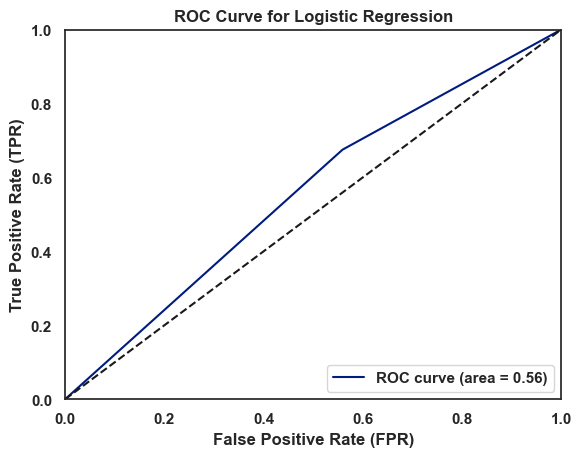

----------------------------------------


In [38]:
KN_Classifier = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)
evaluate_model(KN_Classifier,  x_train_scaled_df, y_train, x_test_scaled_df, y_test)

In [63]:
params = {'learning_rate' :np.arange(0.1, .6, 0.01),
          'n_estimators' : range(1,100,10)
        
}

Ada_grid_model = GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',random_state=33), param_grid=params, cv=3, scoring='accuracy',verbose=3, n_jobs=1,error_score='raise')
Ada_grid_model.fit(x_train_scaled_df,y_train)

print(Ada_grid_model.best_params_,'\n',Ada_grid_model.best_score_)




Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV 1/3] END .learning_rate=0.1, n_estimators=1;, score=0.773 total time=   0.0s
[CV 2/3] END .learning_rate=0.1, n_estimators=1;, score=0.810 total time=   0.0s
[CV 3/3] END .learning_rate=0.1, n_estimators=1;, score=0.809 total time=   0.0s
[CV 1/3] END learning_rate=0.1, n_estimators=11;, score=0.773 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=11;, score=0.710 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=11;, score=0.752 total time=   0.1s
[CV 1/3] END learning_rate=0.1, n_estimators=21;, score=0.864 total time=   0.1s
[CV 2/3] END learning_rate=0.1, n_estimators=21;, score=0.710 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=21;, score=0.752 total time=   0.1s
[CV 1/3] END learning_rate=0.1, n_estimators=31;, score=0.864 total time=   0.2s
[CV 2/3] END learning_rate=0.1, n_estimators=31;, score=0.710 total time=   0.1s
[CV 3/3] END learning_rate=0.1, n_estimators=

Accuracy Test  - 0.9033333333333333
Accuracy Train - 0.9395161290322581

Precision Test  - 0.905736434108527
Precision Train - 0.9397735407041062

Recall Test  - 0.9033333333333333
Recall Train - 0.9395161290322581

F1_score Test  - 0.9042424242424242
F1_score Train - 0.9395072770143915

Confusion Matrix Test  -- 
[[203  17]
 [ 12  68]]
Confusion Matrix Train -- 
[[460  36]
 [ 24 472]]

Classification Report Test
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       220
           1       0.80      0.85      0.82        80

    accuracy                           0.90       300
   macro avg       0.87      0.89      0.88       300
weighted avg       0.91      0.90      0.90       300

Classification Report Train
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       496
           1       0.93      0.95      0.94       496

    accuracy                           0.94       992
   macro a

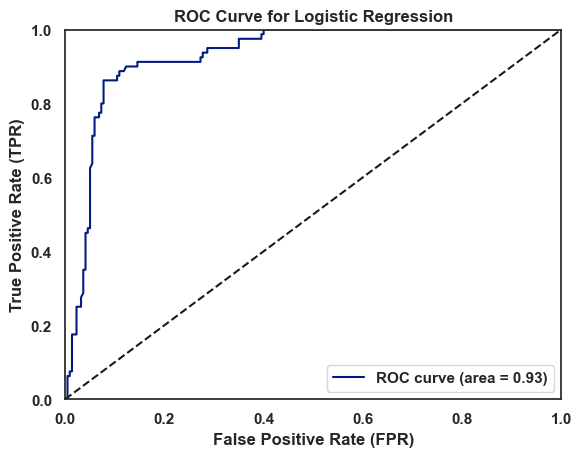

----------------------------------------


In [42]:
ADA_Classifier = AdaBoostClassifier(n_estimators=71,algorithm='SAMME',learning_rate=.5,random_state=33)
evaluate_model(ADA_Classifier,  x_train_scaled_df, y_train, x_test_scaled_df, y_test)

In [41]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
RF_cv_score = cross_val_score(ADA_Classifier,x_train_scaled_df,y_train, cv=kf)
print(f'Cross validations scores \n\n {RF_cv_score}\n\n')
print(f'Cross validations scores mean \n\n {np.mean(RF_cv_score)}')

Cross validations scores 

 [0.91       0.89       0.93939394 0.94949495 0.92929293 0.91919192
 0.91919192 0.95959596 0.95959596 0.95959596]


Cross validations scores mean 

 0.9335353535353537


In [43]:
os.makedirs('pkls', exist_ok=True)
with open(r'pkls/ADA_Classifier.pkl', 'wb') as f:
    pickle.dump(ADA_Classifier,f)